# Importing Required Libraries


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.optimize import curve_fit
from scipy.special import gamma
from sklearn.metrics import r2_score
import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn")

%matplotlib inline

In [2]:
# Defining all the functions of the disributions

def gauss(x, mu, sigma, scale):
    return scale * np.exp(-1 * ((x - mu) ** 2) / (2 * (sigma ** 2) )) 

def weib(x, k, a, b, g):
    return k * g * b * (a ** b) * np.exp(-1 * g * ((a / x)  ** b)) / (x ** (b + 1))

def lognormal(x, f, kp):
    return np.exp(-(np.log(x) - kp)**2 / (2*(f**2)))/(x*f*2.51)

def loglogistic(x, kb, kf):
    return (kf/kb * np.power(x/kb, kf-1))/np.power((1+np.power(x/kb, kf)), 2)

#The Iterative algorithm - as suggeseted in the paper
def iterativeCurveFit(func, x, y):
    outliersweight = None
    for i in range(10):
        popt, pcov = curve_fit(func, x, y, sigma=outliersweight, maxfev=100000)
        pred = np.array([func(px, *popt) for px in x])
        old = outliersweight
        outliersweight = np.abs(pred - y)
        outliersweight = 1 - np.tanh(outliersweight)
        outliersweight = outliersweight / np.max(outliersweight)
        outliersweight = softmax(1 - outliersweight)
        if i > 1 and sum(abs(old - outliersweight)) < 0.001:
            break
    
    return popt, pcov

#The expectedEnd function, outputs -> EndDate, and Number of cases
def expectedEnd(name , curve, index, startDate):
    dic = {}
    dic['x'] = np.arange(1, 4*index)
    dic[name] = (curve*y_data_cases_max).astype('int')
    df = pd.DataFrame(dic, columns= list(dic.keys()))
    if df[-1:][name].values < 1:
        end_index = min(df[(df.index > index) & (df[name] < 1)].index)
    else:
        end_index = max(df[-1:].index)
    cases = df.iloc[end_index, 1]
    end_date = datetime.datetime.strptime(startdate, '%Y-%m-%d') + datetime.timedelta(days = end_index)
    return end_date.strftime('%Y-%m-%d'), cases

In [8]:

# from google.colab import files
# files.upload()


# If using jupyter then use directly or If using colab-please uncomment the upper lines of code 
# and upload the files (owid-covid-data.csv), (states.csv) and (cowin_vaccine_data_statewise.csv) from your local computer

df = pd.read_csv('owid-covid-data.csv')
ind = df[df['location'] == 'India']
ind.reset_index(inplace = True)
ind.head()

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,33559,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
1,33560,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
2,33561,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
3,33562,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
4,33563,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645


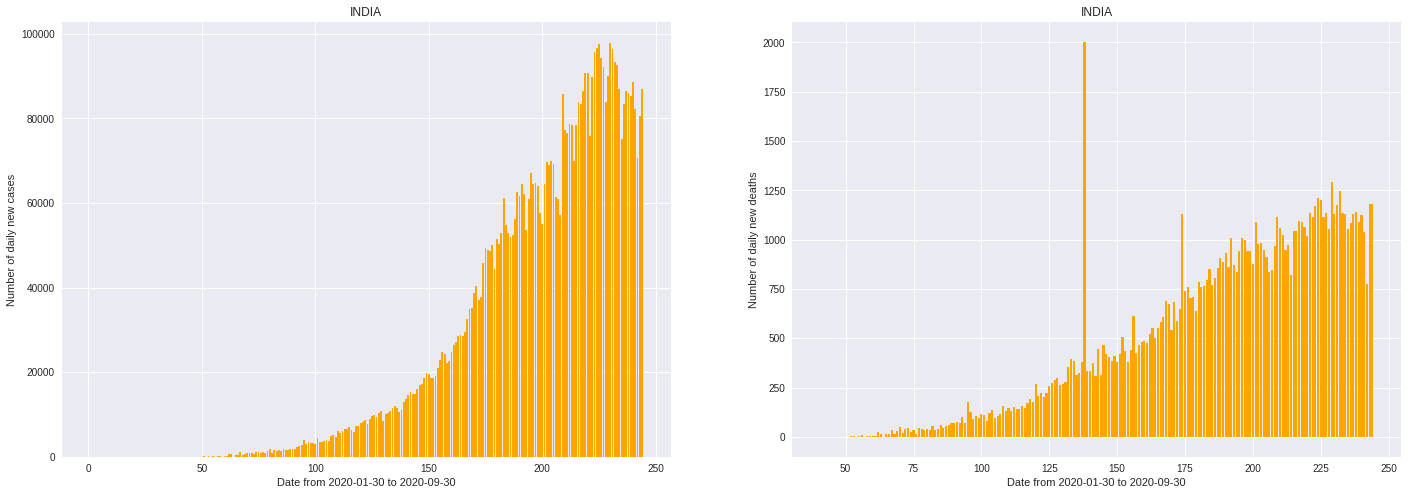

In [9]:
# indexing the data
index = 245
startdate = min(ind.date)
enddate = max(ind.date[1:index])

# Defining the data needed for analysis
x_data, y_data_cases, y_data_deaths = (ind.index.values[1:index], ind.new_cases.values[1:index], ind.new_deaths.values[1:index])
x_data_max, y_data_cases_max, y_data_deaths_max = (max(x_data), max(y_data_cases), max(y_data_deaths))

#Plotting Cases and Deaths vs number of days
fig, axes = plt.subplots(1, 2, figsize=(24,8))
      
axes[0].bar(x_data, y_data_cases,color = 'orange')
axes[0].set_title("INDIA")
axes[0].set_xlabel('Date from {} to {}'.format(startdate, enddate))
axes[0].set_ylabel("Number of daily new cases")

axes[1].bar(x_data, y_data_deaths,color = 'orange')
axes[1].set_title("INDIA")
axes[1].set_xlabel('Date from {} to {}'.format(startdate, enddate))
axes[1].set_ylabel("Number of daily new deaths");
plt.savefig('India_data.png')

#Normalizing the data
xdata = x_data/x_data_max
ydata_cases = y_data_cases/y_data_cases_max
ydata_deaths = y_data_deaths/y_data_deaths_max

#Optimized and Covarince matrix - Curve Fitting
popt_ind_weib, pcov_ind_weib = iterativeCurveFit(weib, xdata, ydata_cases)
popt_ind_gauss, pcov_ind_gauss = iterativeCurveFit(gauss, xdata, ydata_cases)
popt_ind_lognormal, pcov_ind_lognormal = iterativeCurveFit(lognormal, xdata, ydata_cases)
popt_ind_loglogistic, pcov_ind_loglogistic = iterativeCurveFit(loglogistic, xdata, ydata_cases)

# split data into train/test to calculate evaluation metrics 
# The training:testing data is 80:20
msk = np.random.rand(index-1) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata_cases[msk]
test_y = ydata_cases[~msk]


#Predictions for evaluation of metrics
y_hat = weib(test_x, *popt_ind_weib)
z_hat = gauss(test_x, *popt_ind_gauss)
t_hat = lognormal(test_x, *popt_ind_lognormal)
l_hat = loglogistic(test_x, *popt_ind_loglogistic)


# Defining range of x
xt = np.arange(1, 4*index)
xt = 4*xt/max(xt)

#The curves corresponding to all the functions
y = weib(xt, *popt_ind_weib)
z = gauss(xt, *popt_ind_gauss)
t = lognormal(xt, *popt_ind_lognormal)
l = loglogistic(xt, *popt_ind_loglogistic)

#Creating a list to create a dataframe which has all the evaluted metrics
india = []
models = ['Weibull', 'Gauss', 'LogNormal', ' LogLogistic']
hats = [y_hat, z_hat, t_hat, l_hat]
names = ['y', 'z', 't', 'l']
curves = [y, z, t, l]

for i in range(4):
    india.append({
        'Function' : models[i],
        'Mean Absolute Error' : np.mean(np.absolute(hats[i] - test_y)),
        'Mean Squared Error' : np.mean((hats[i] - test_y) ** 2),
        'R2-Score' : r2_score(hats[i] , test_y),
        'Expected_Last_date': expectedEnd(names[i], curves[i], index, startdate)[0],
        'Expected_cases': expectedEnd(names[i], curves[i], index, startdate)[1]
    })

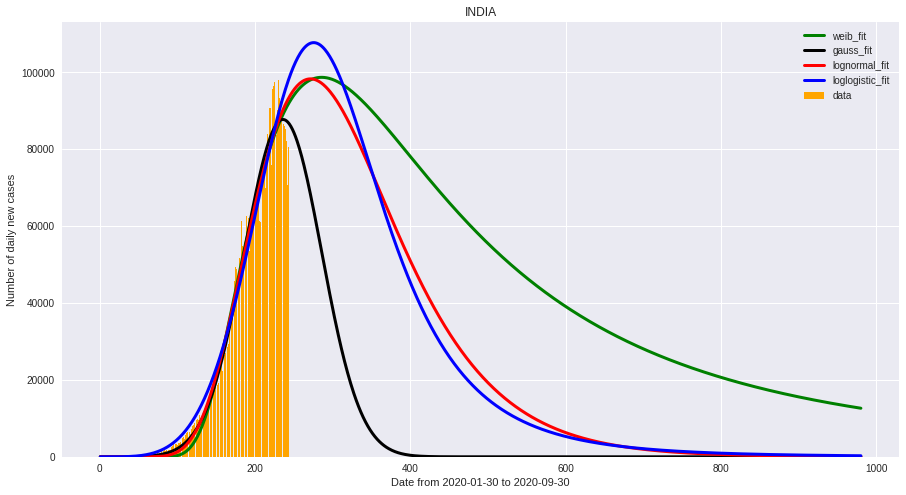

In [10]:
#plotting the predicted plots
plt.figure(figsize = (15,8))
plt.bar(xdata*x_data_max, ydata_cases*y_data_cases_max, color = 'orange', label = 'data')
plt.plot(xt*index, y*y_data_cases_max, 'green', linewidth = 3.0, label = 'weib_fit')
plt.plot(xt*index, z*y_data_cases_max, 'black', linewidth = 3.0, label = 'gauss_fit')
plt.plot(xt*index, t*y_data_cases_max, 'red', linewidth = 3.0, label = 'lognormal_fit')
plt.plot(xt*index, l*y_data_cases_max, 'blue', linewidth = 3.0, label = 'loglogistic_fit')
plt.title('INDIA')
plt.legend(loc = 'best')
plt.ylabel("Number of daily new cases")
plt.xlabel('Date from {} to {}'.format(startdate, enddate))
plt.savefig('india.png')
plt.show()

In [11]:
df_2 = pd.DataFrame(india, columns= ['Function', 'Mean Absolute Error', 'Mean Squared Error', 'R2-Score', 'Expected_Last_date','Expected_cases'])
df_2.to_csv('FinalMatrics_India.csv')
df_2

,Function,Mean Absolute Error,Mean Squared Error,R2-Score,Expected_Last_date,Expected_cases
0,Weibull,0.032976,0.002381,0.979941,2022-10-04,12627
1,Gauss,0.027419,0.002027,0.983002,2021-05-17,0
2,LogNormal,0.033761,0.002441,0.979328,2022-10-04,73
3,LogLogistic,0.039715,0.003288,0.971518,2022-10-04,271


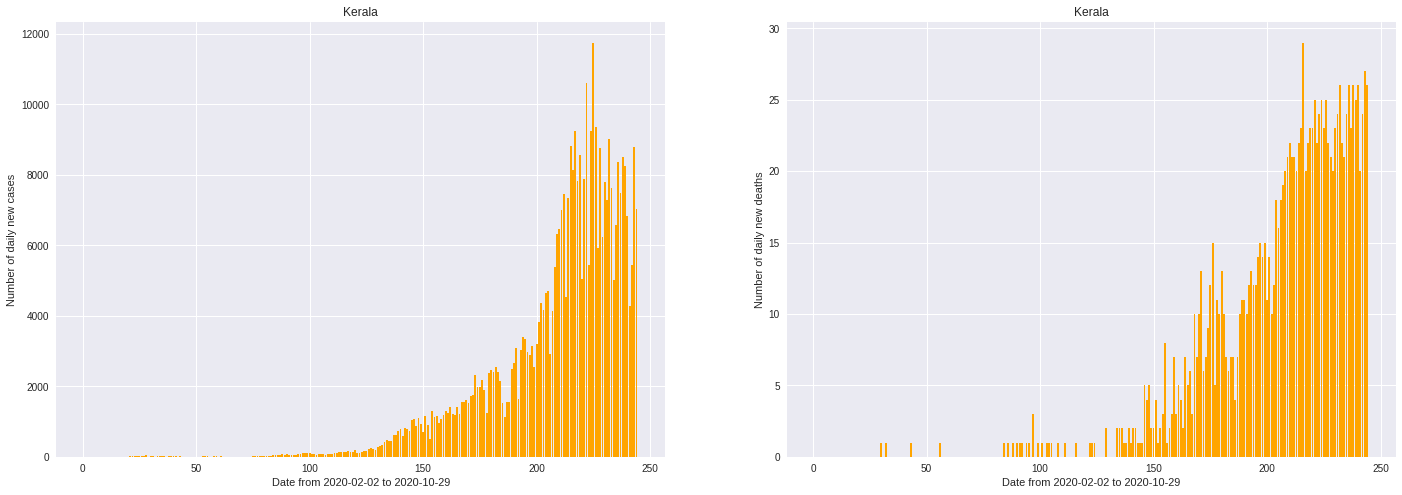

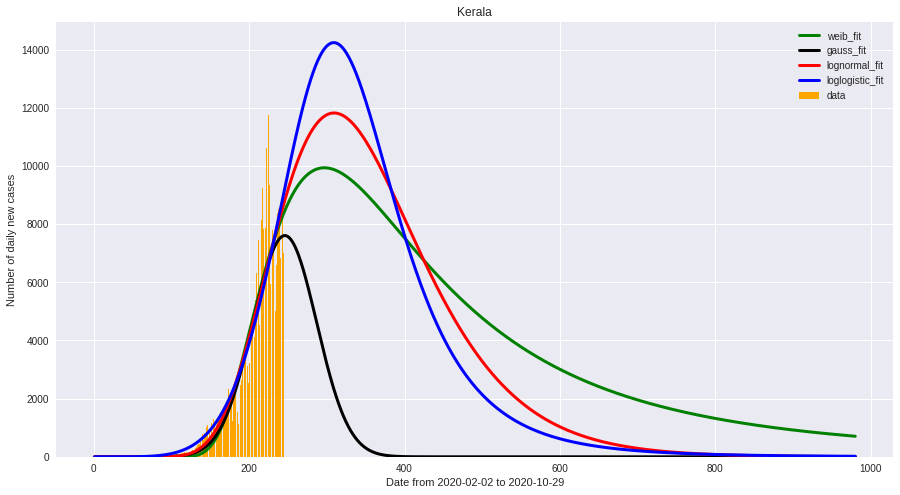

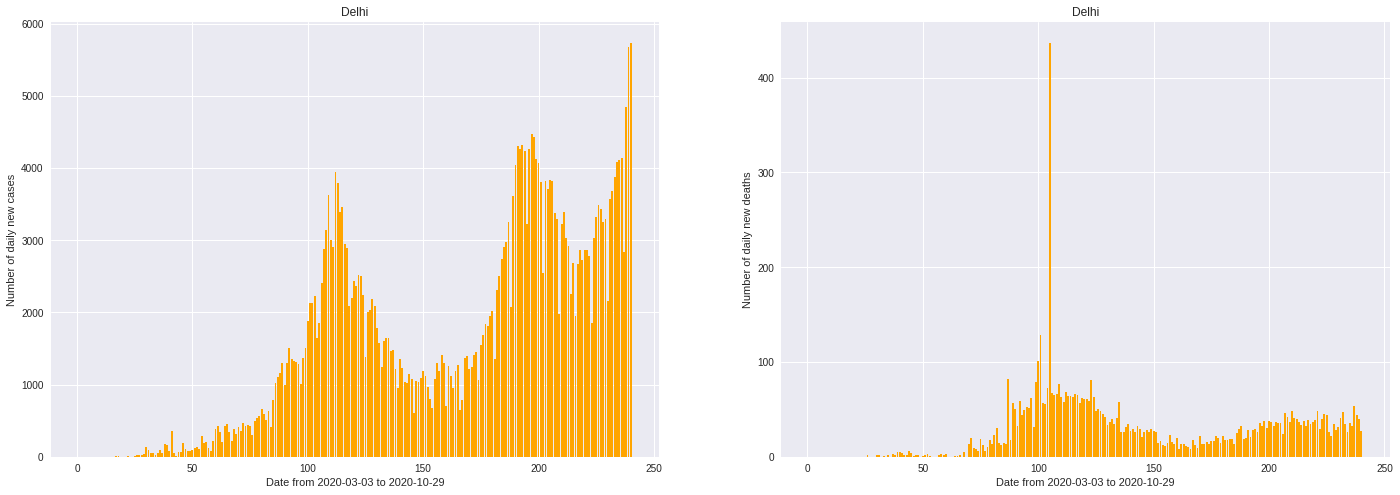

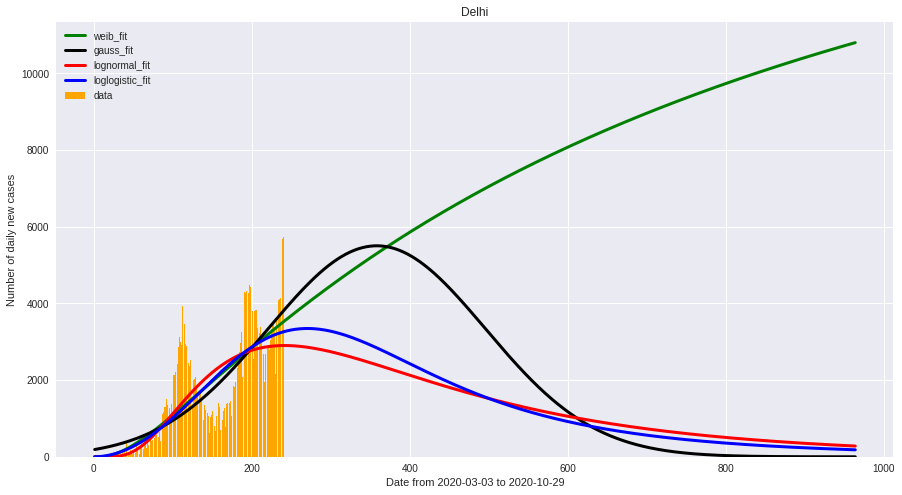

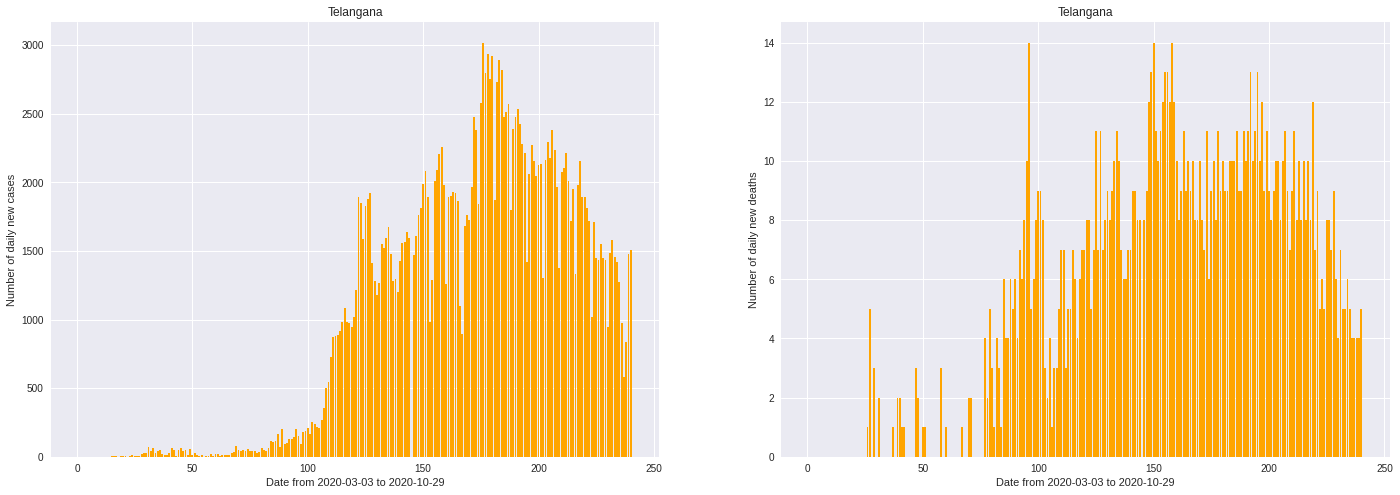

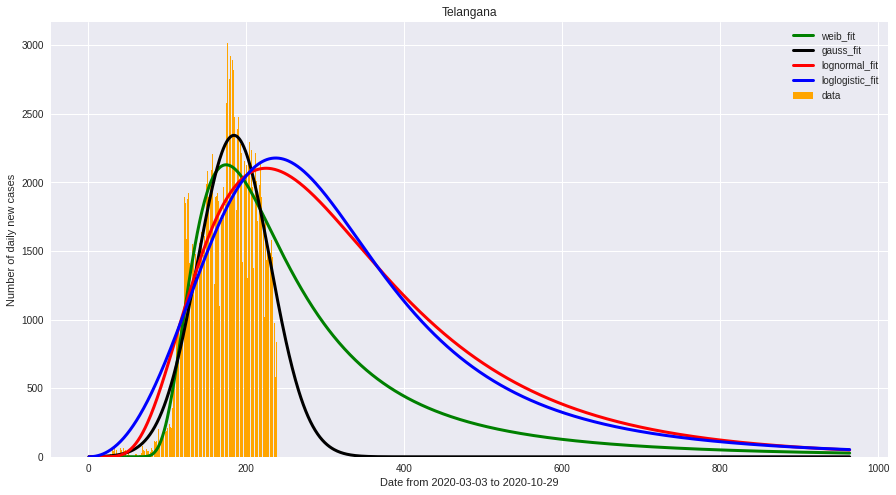

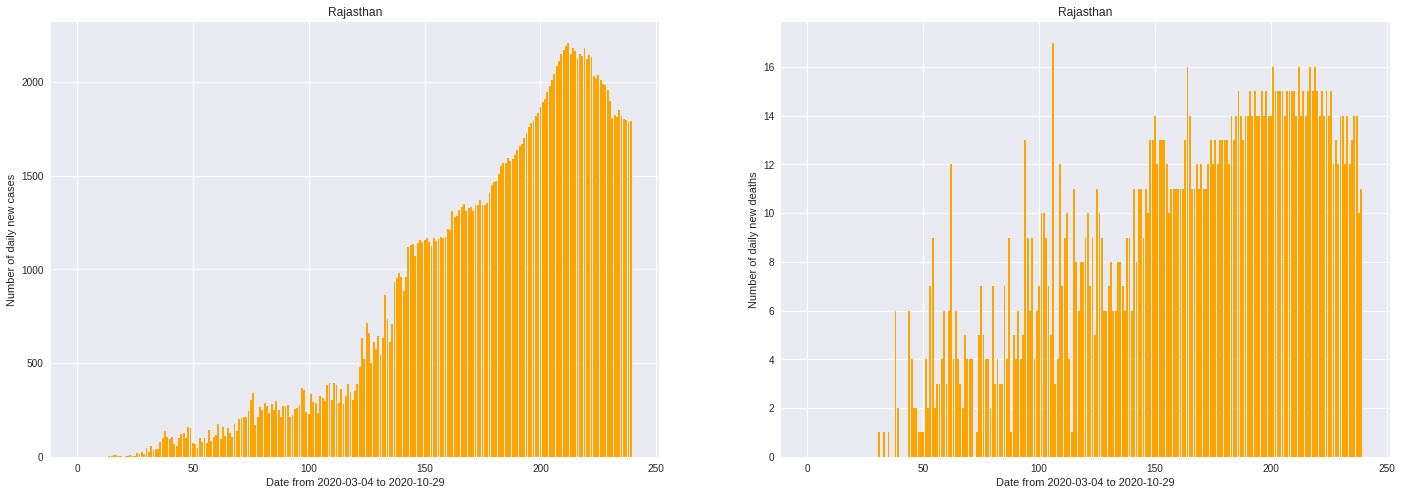

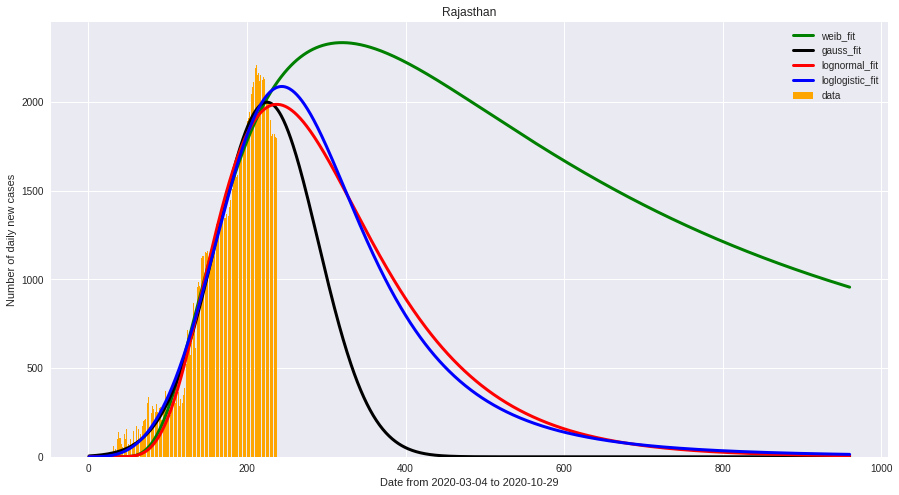

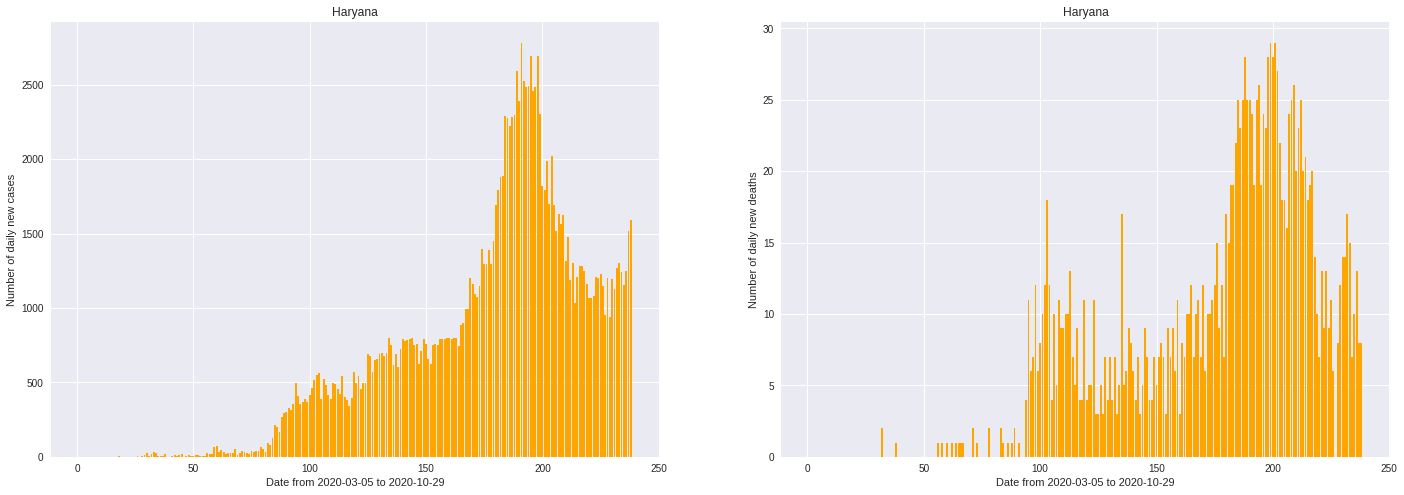

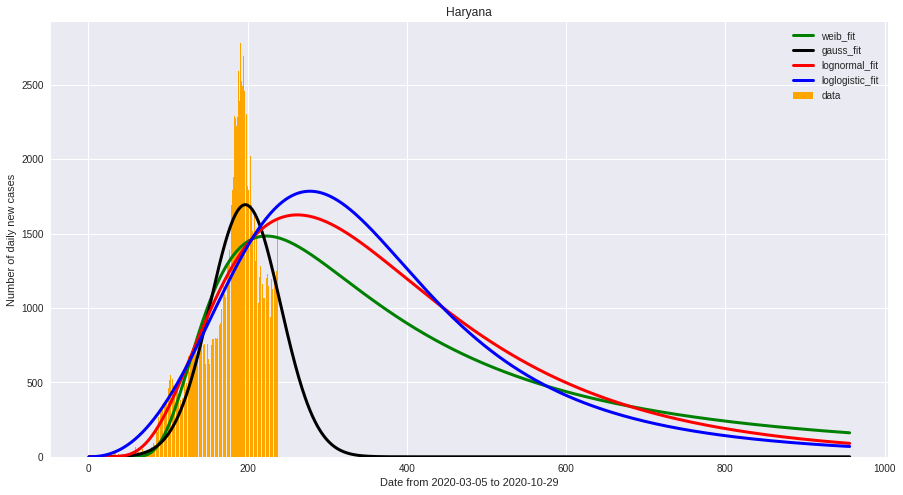

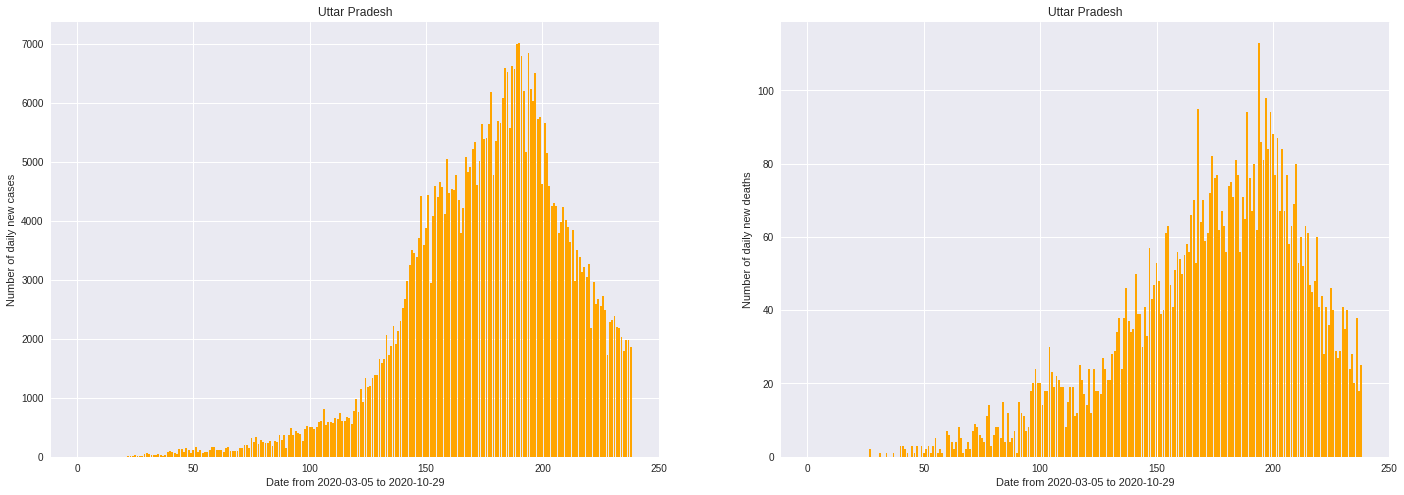

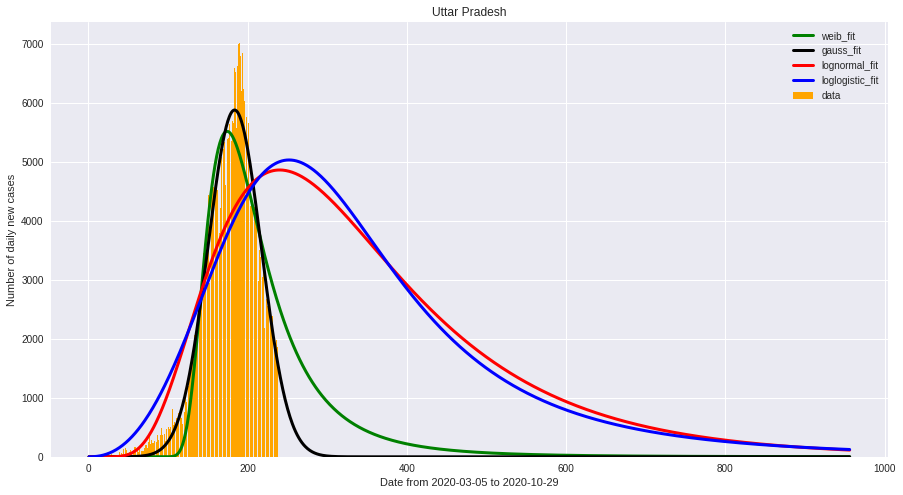

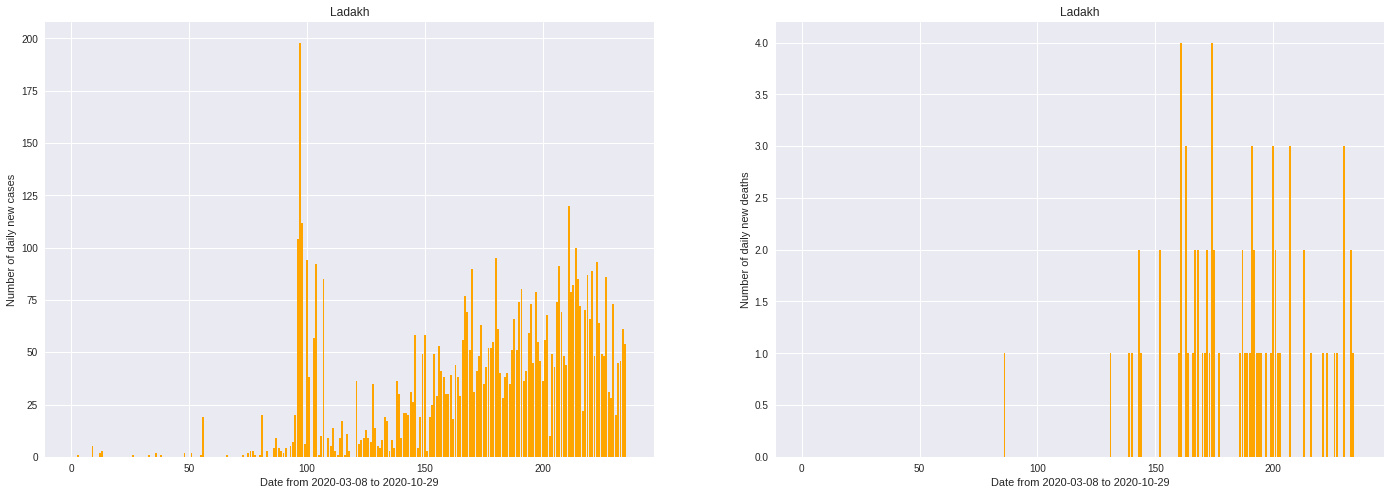

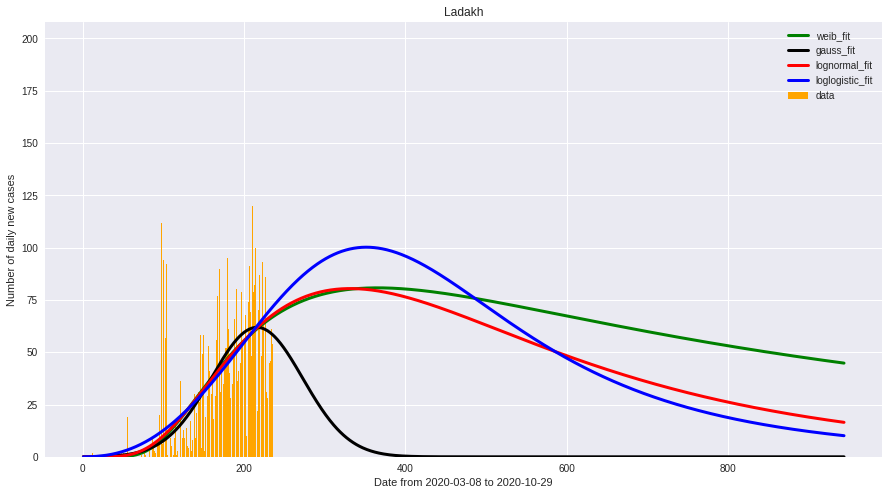

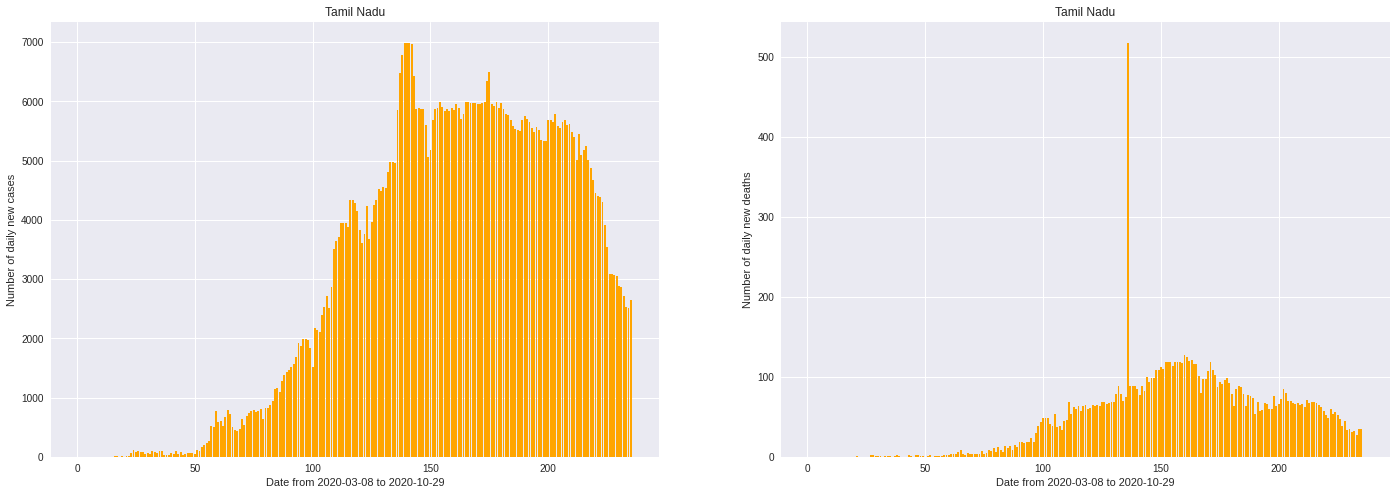

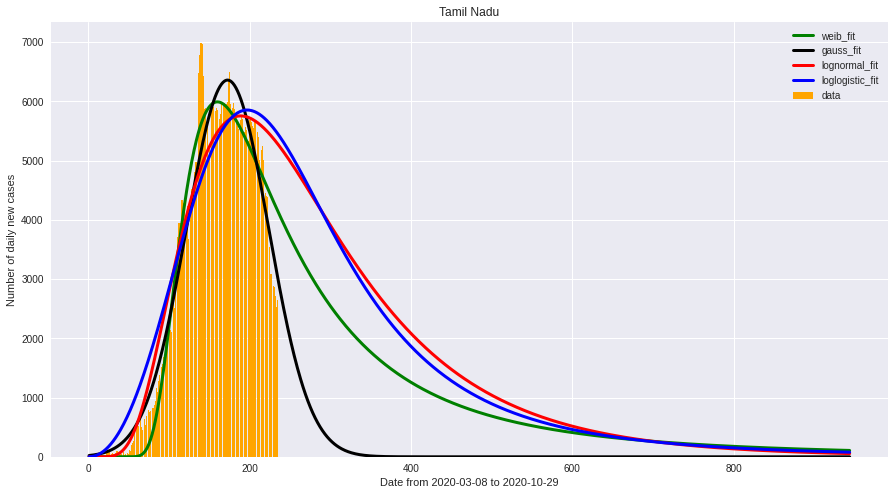

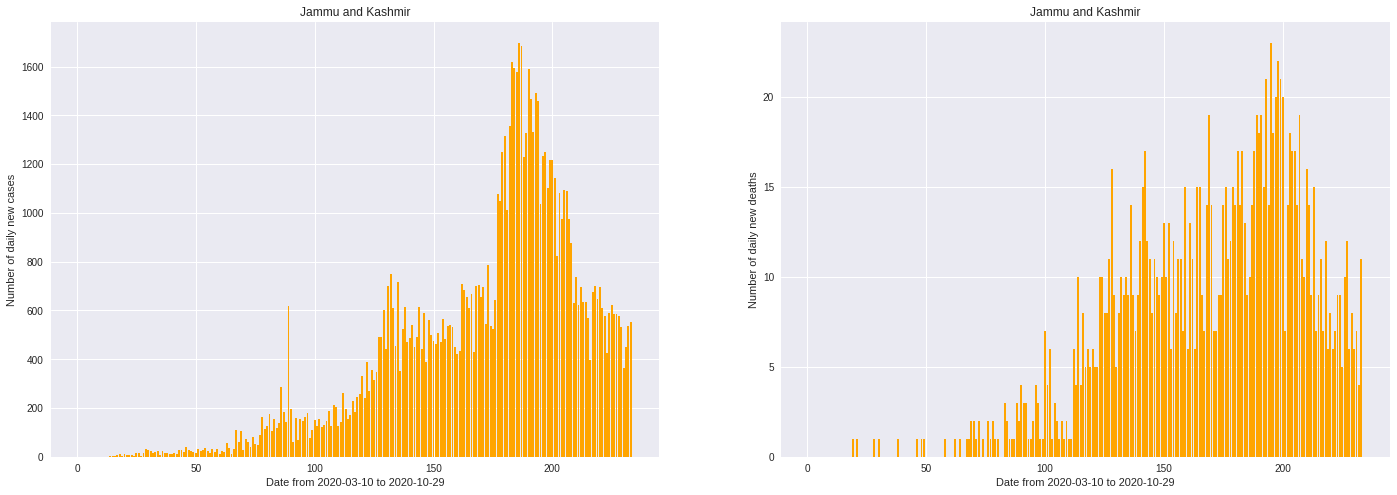

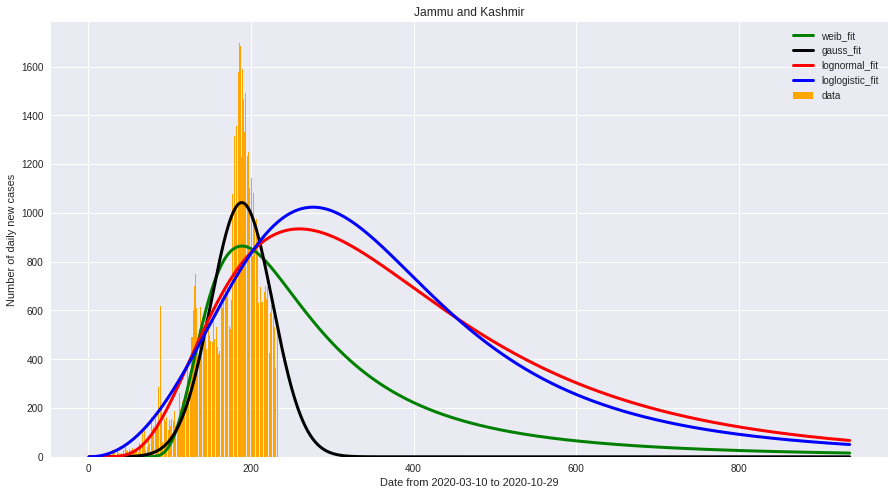

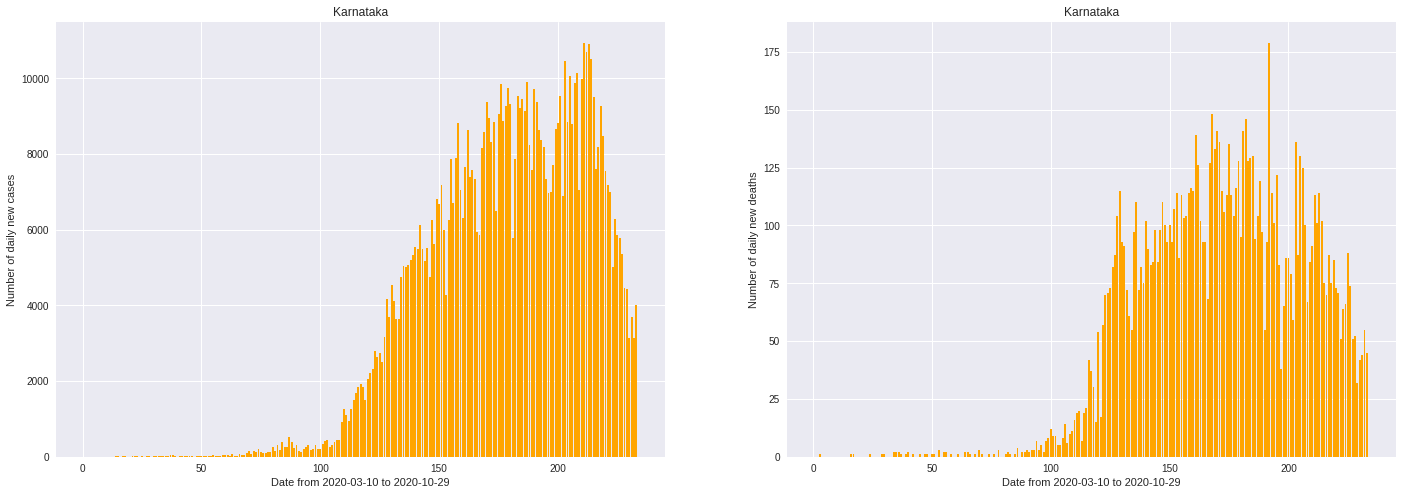

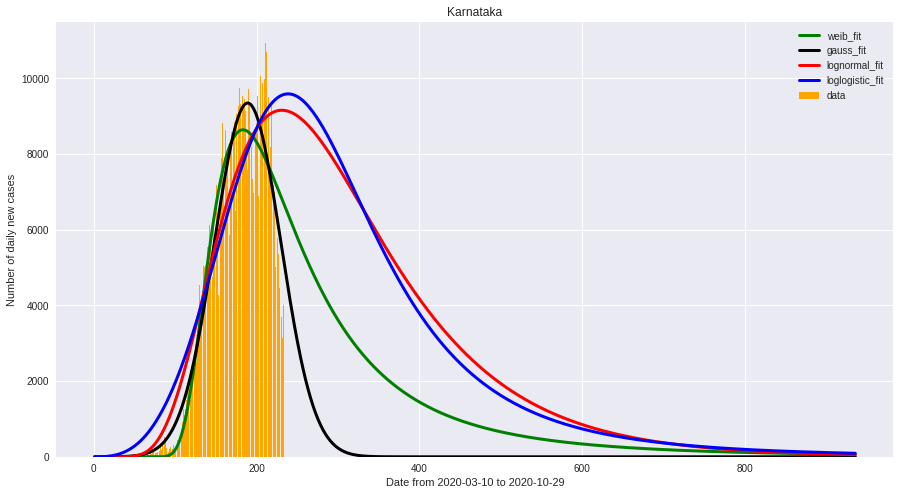

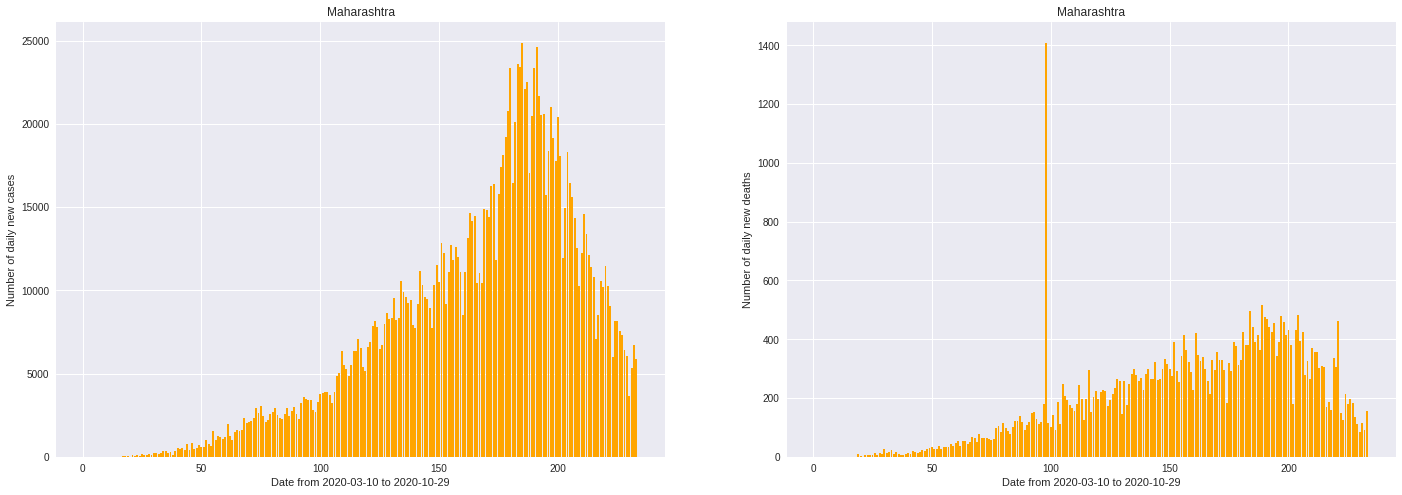

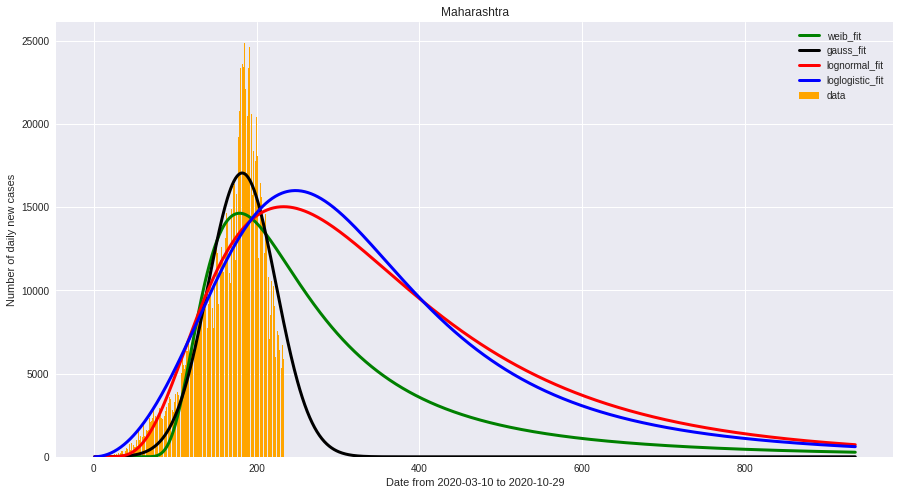

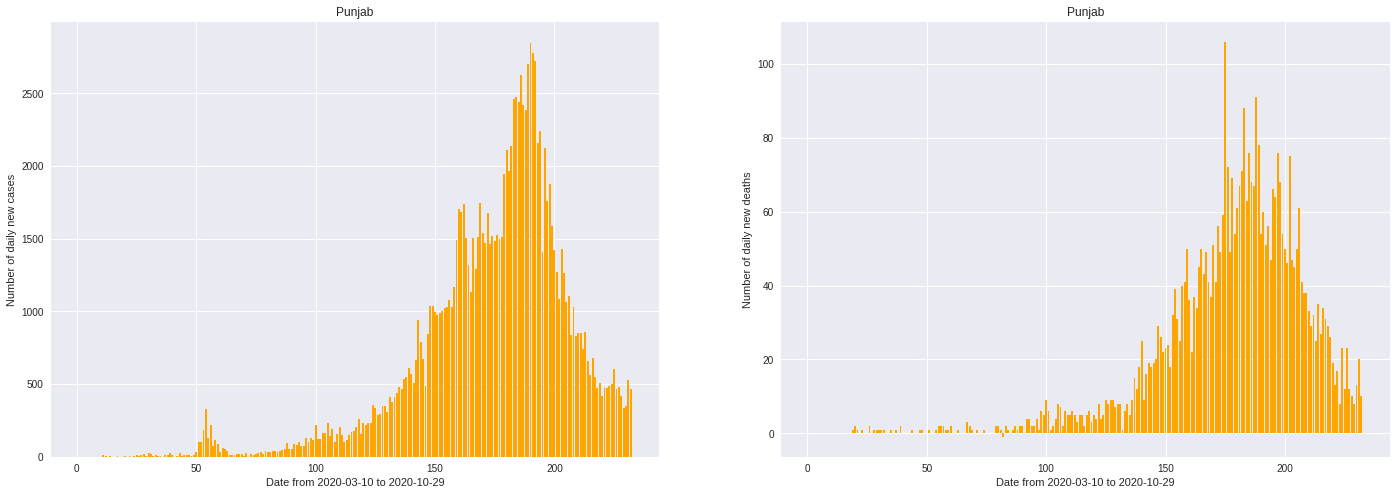

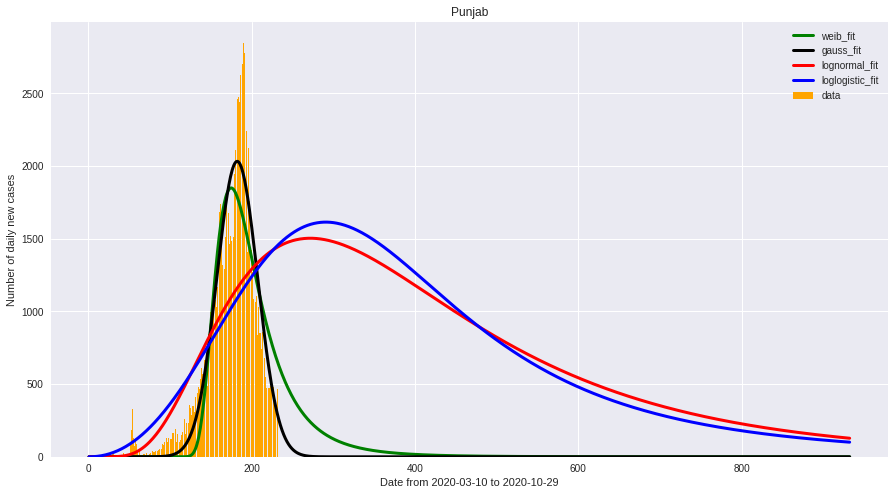

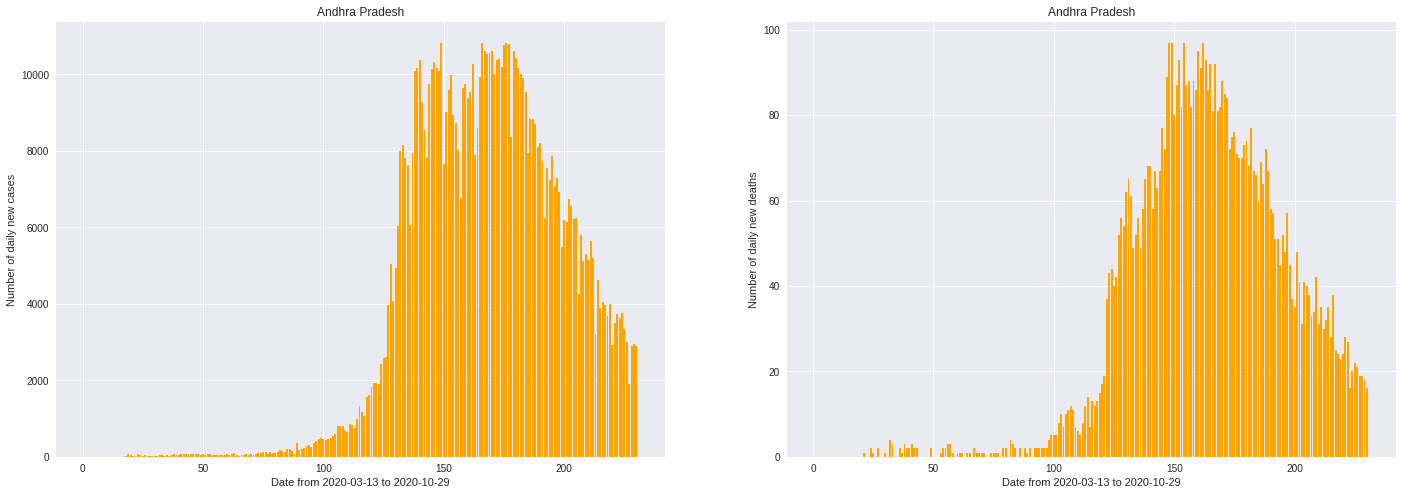

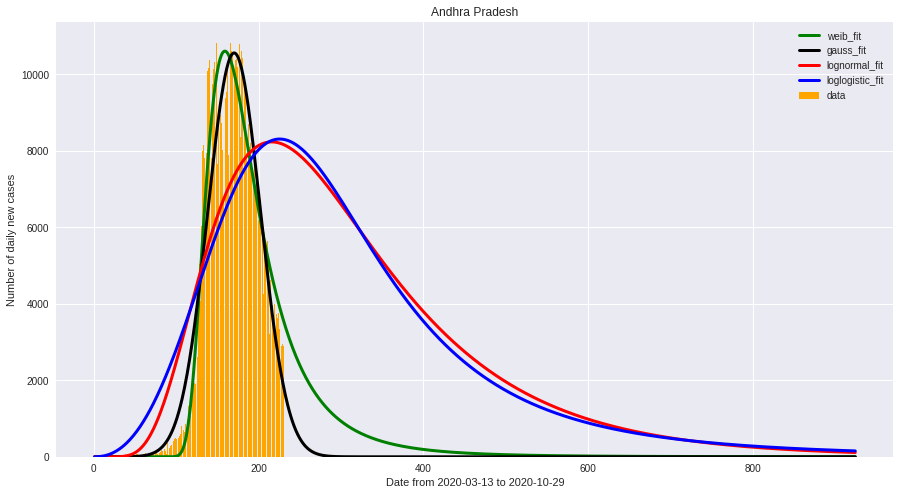

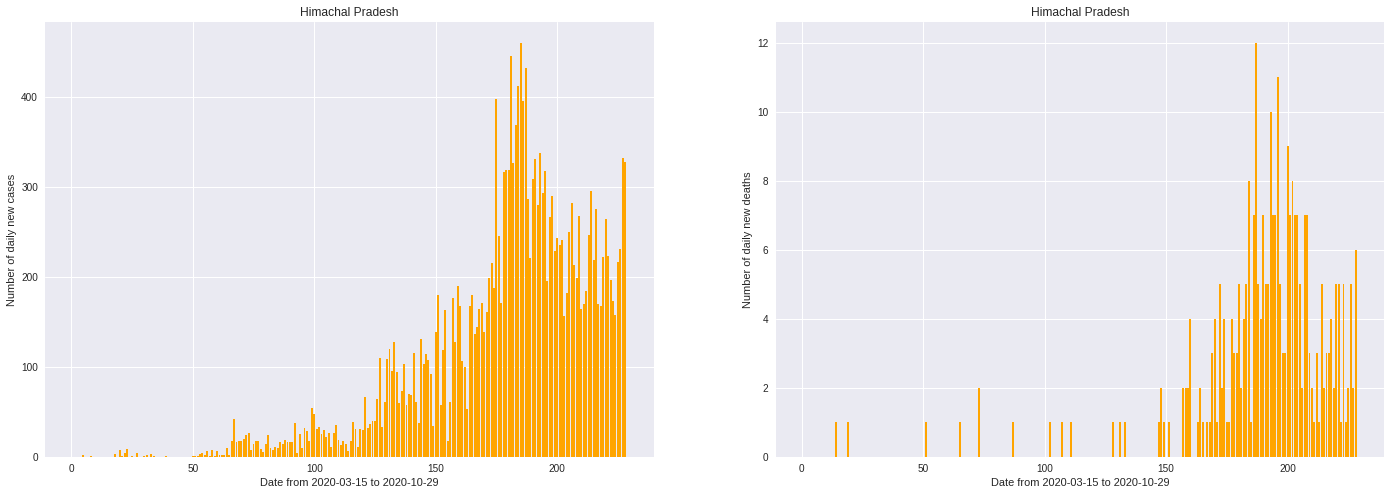

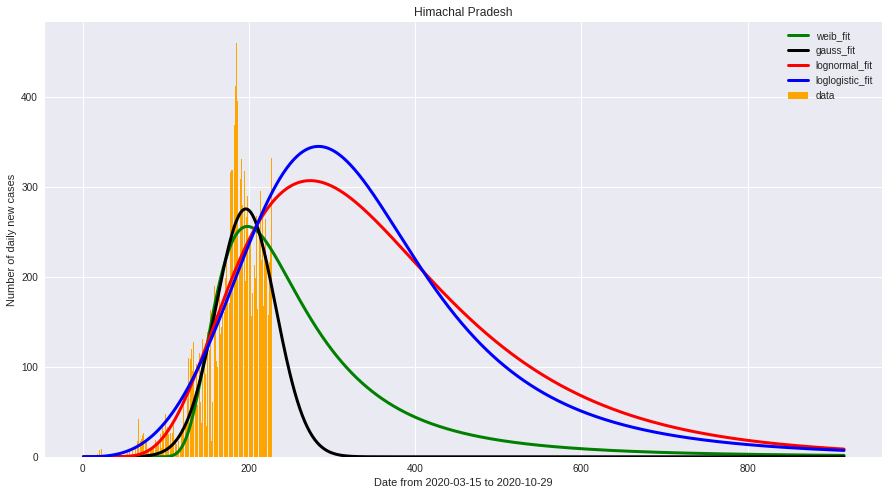

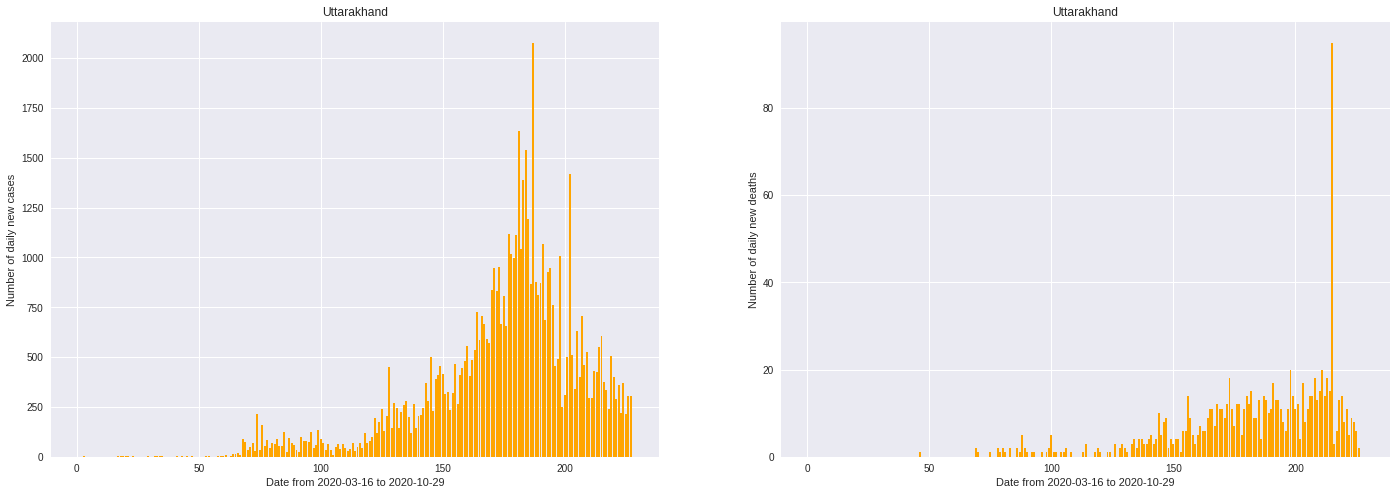

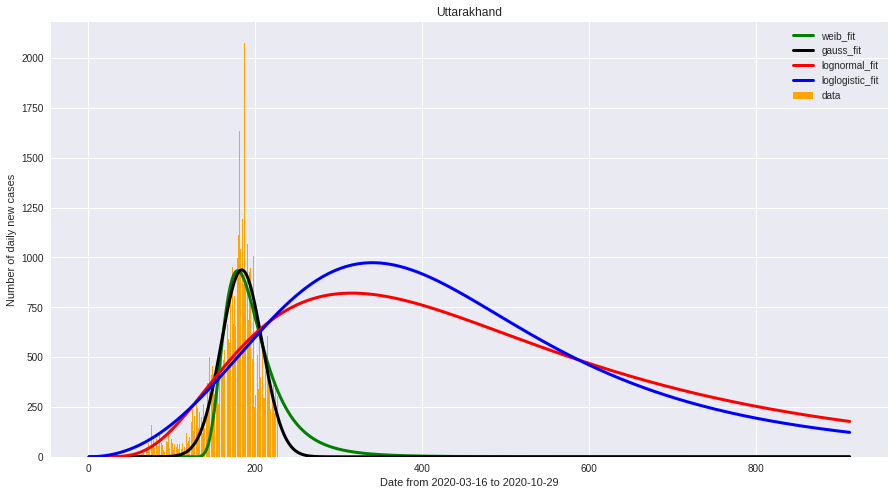

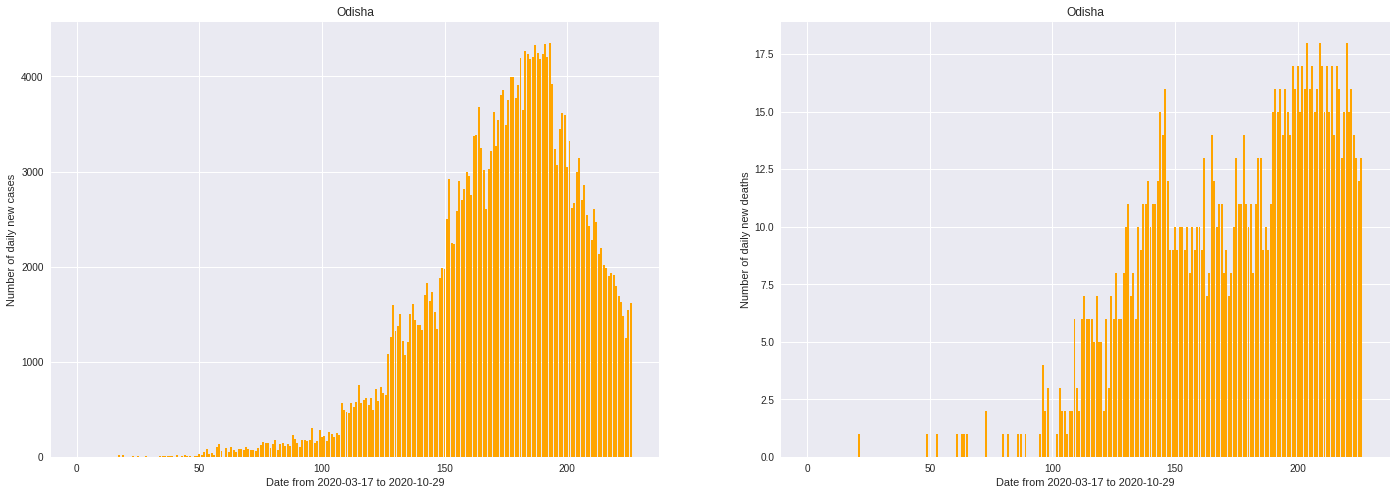

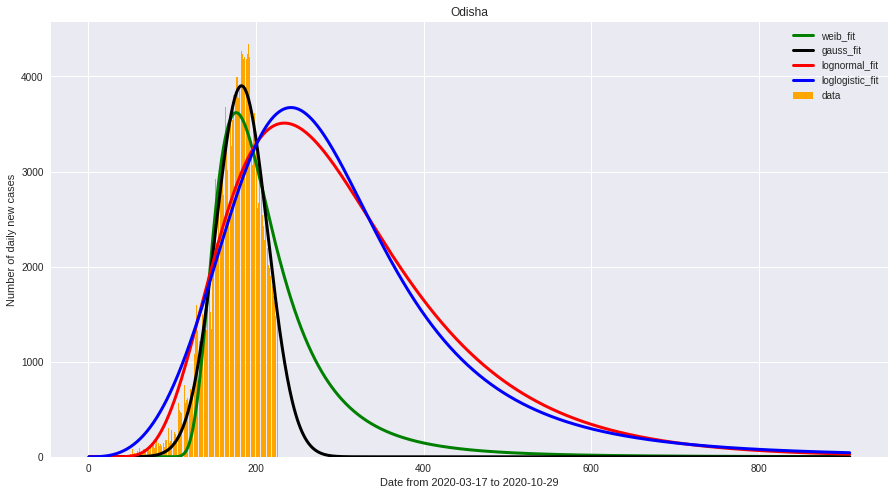

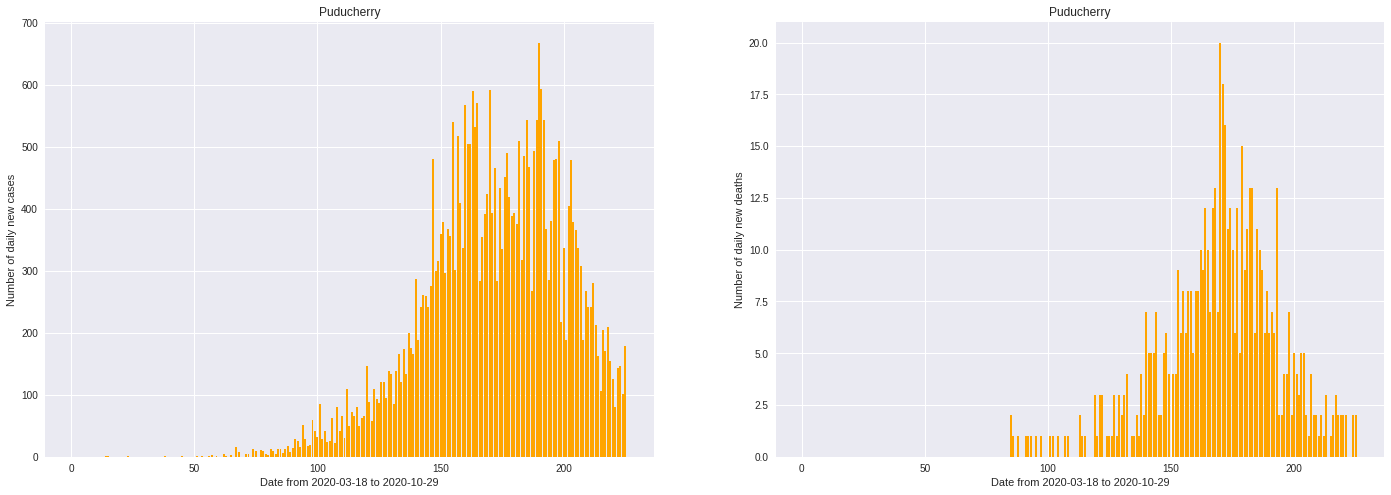

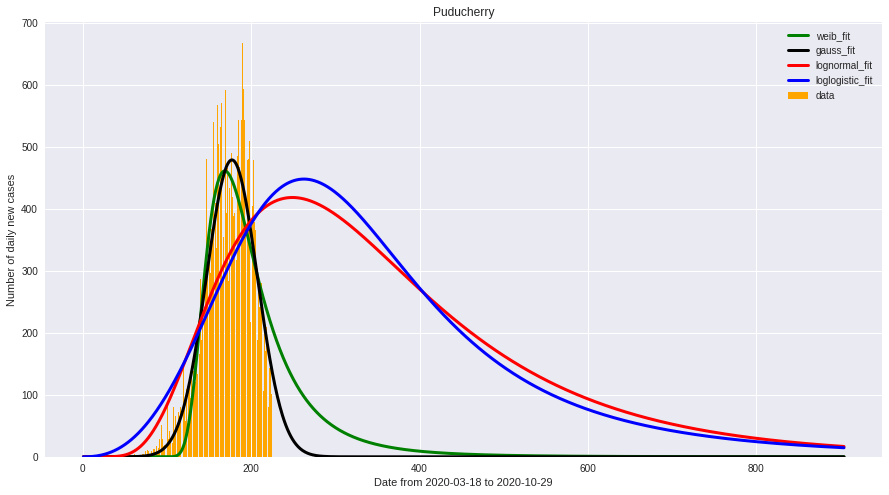

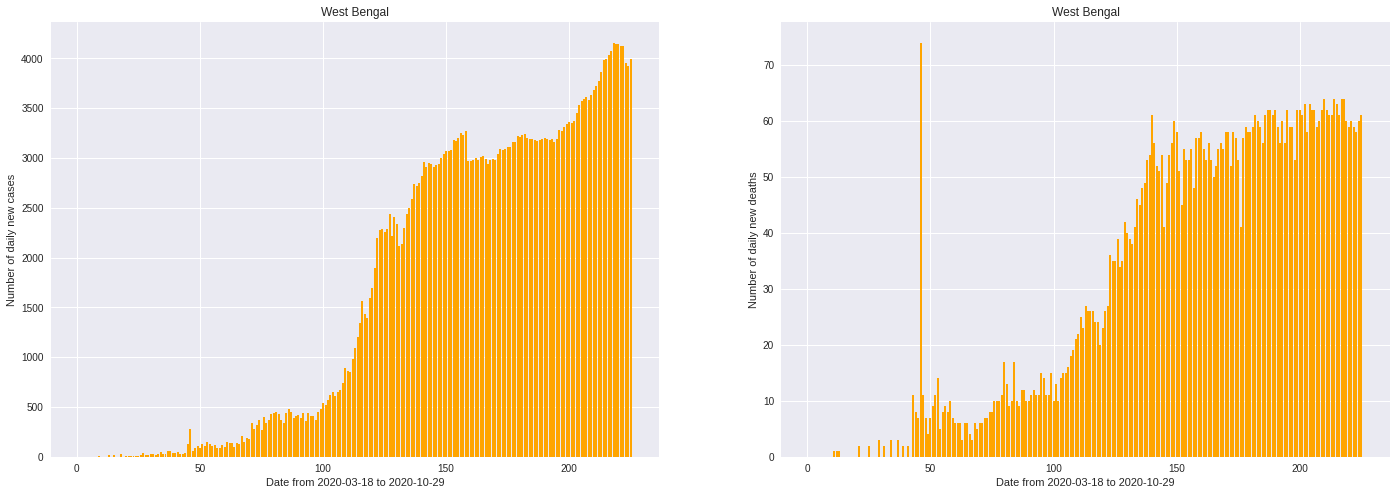

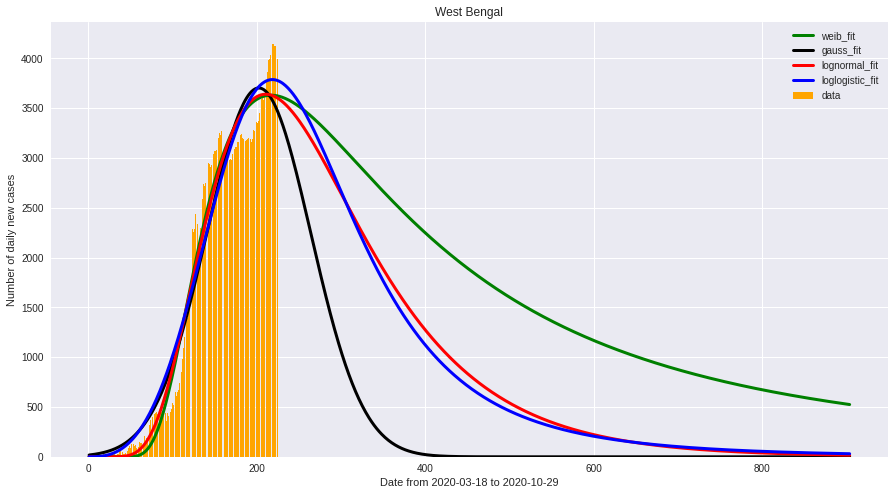

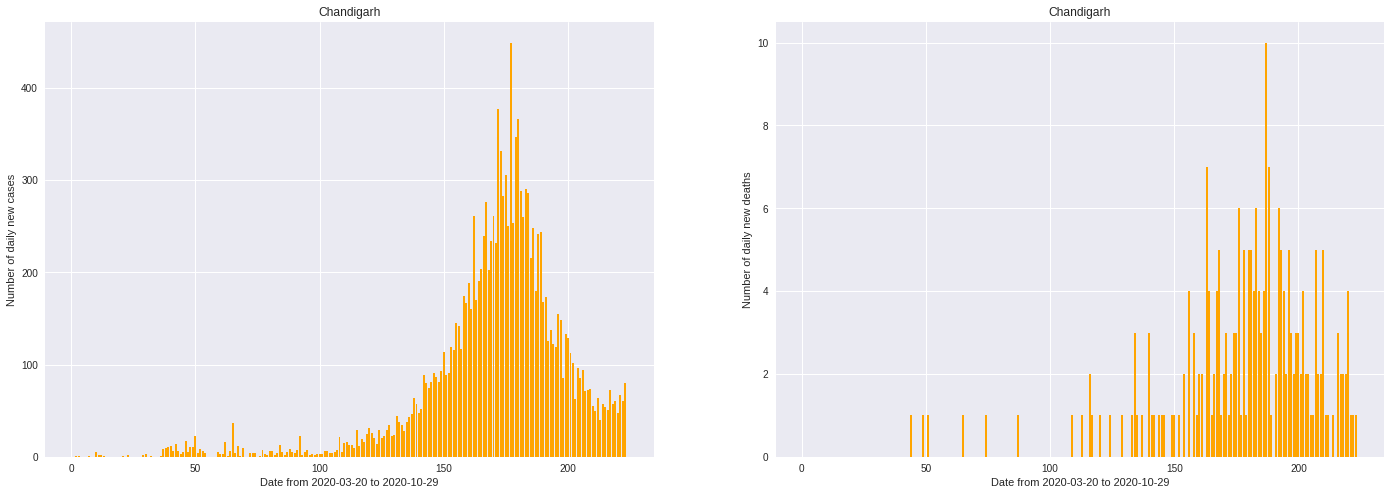

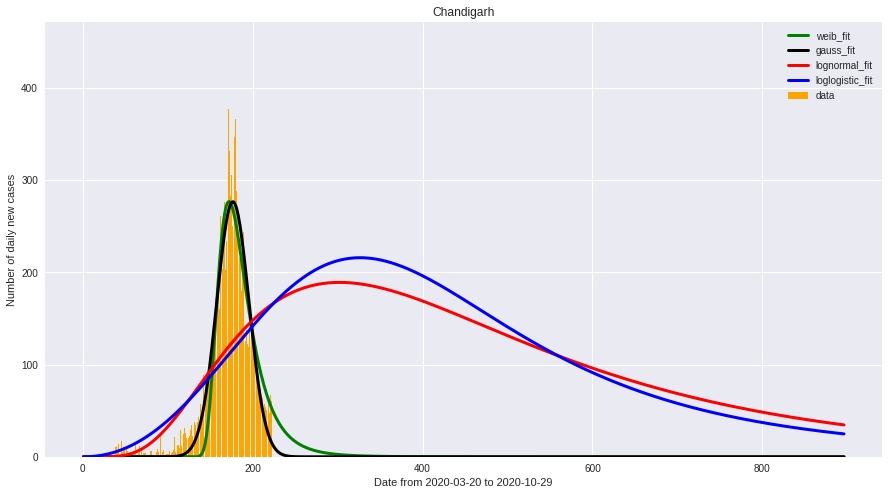

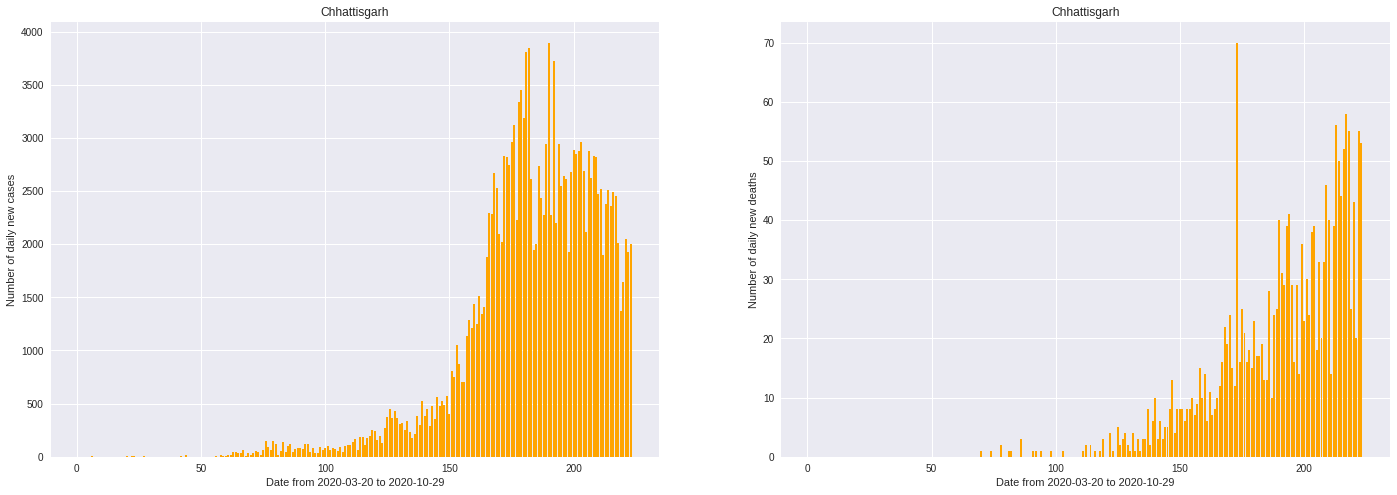

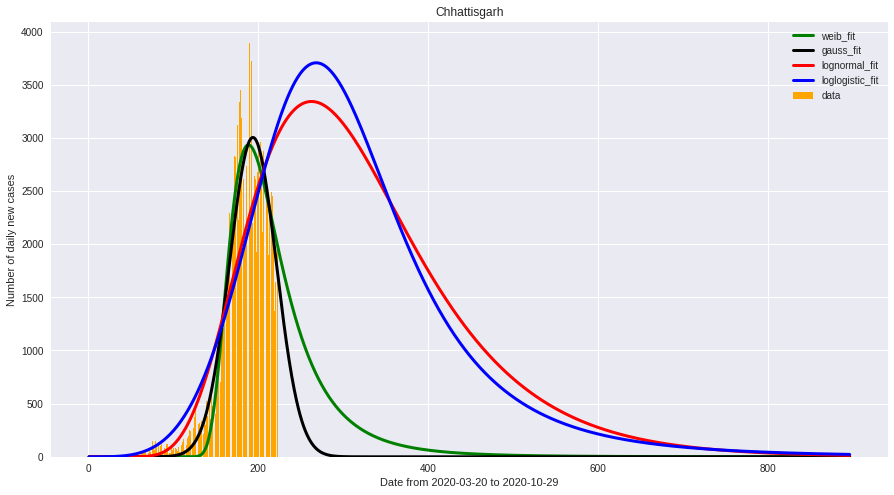

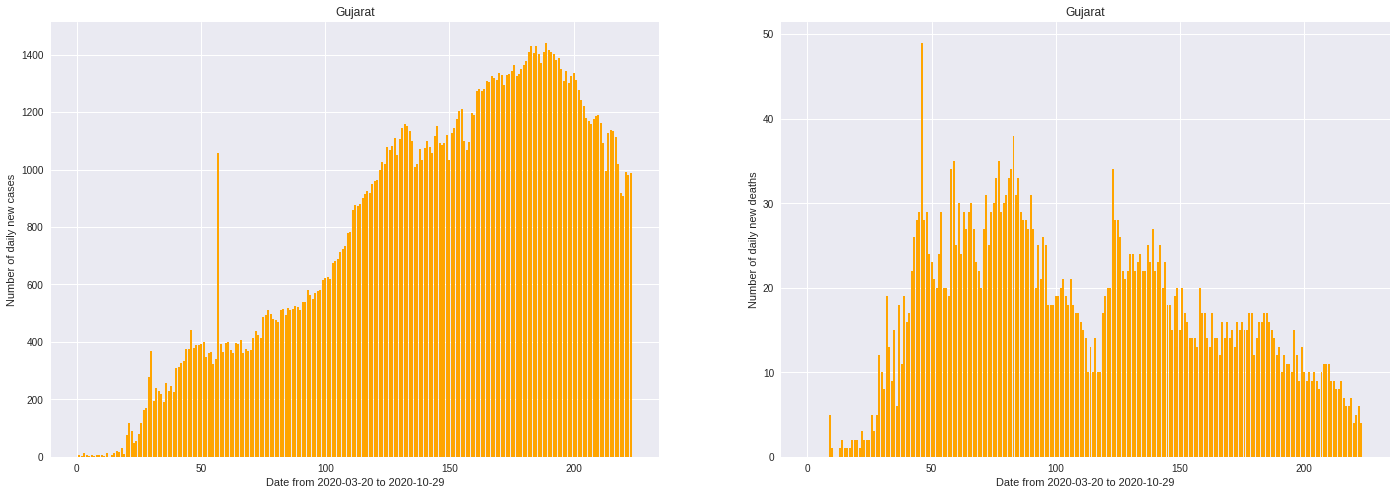

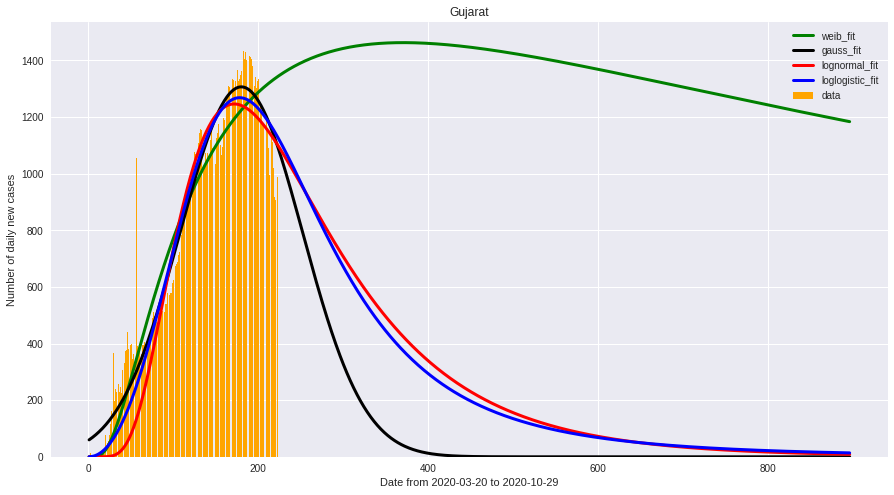

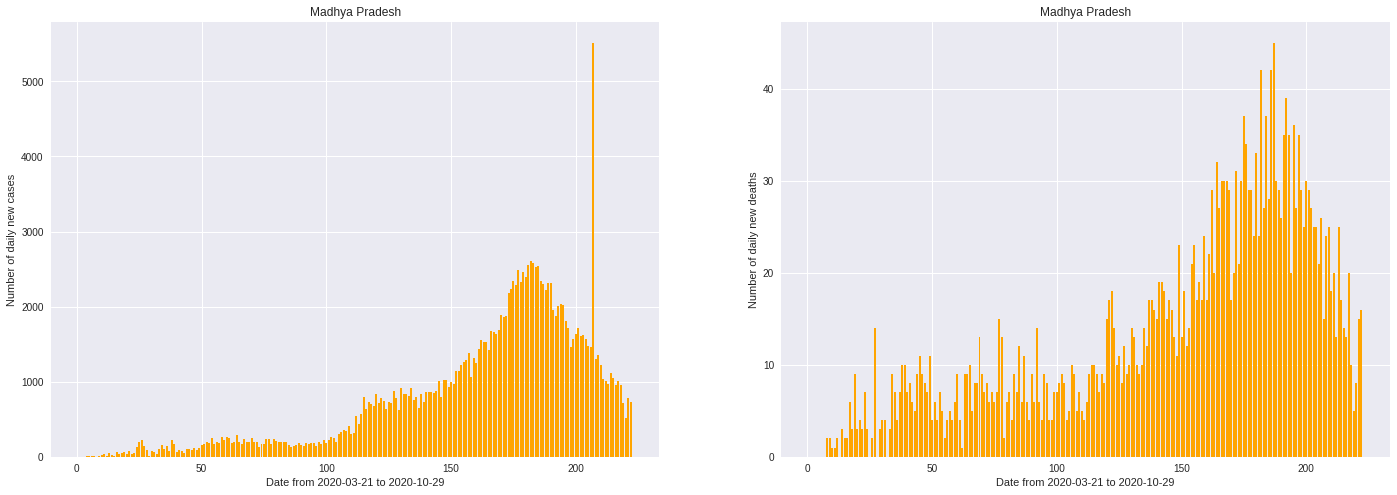

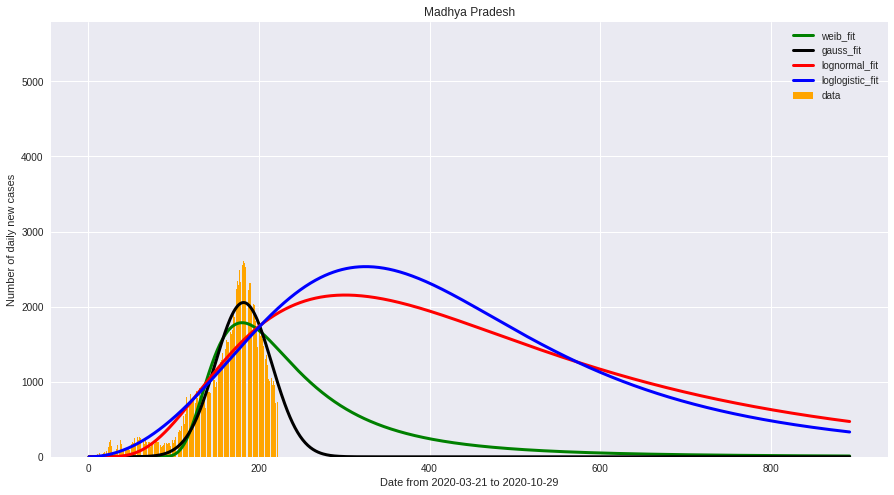

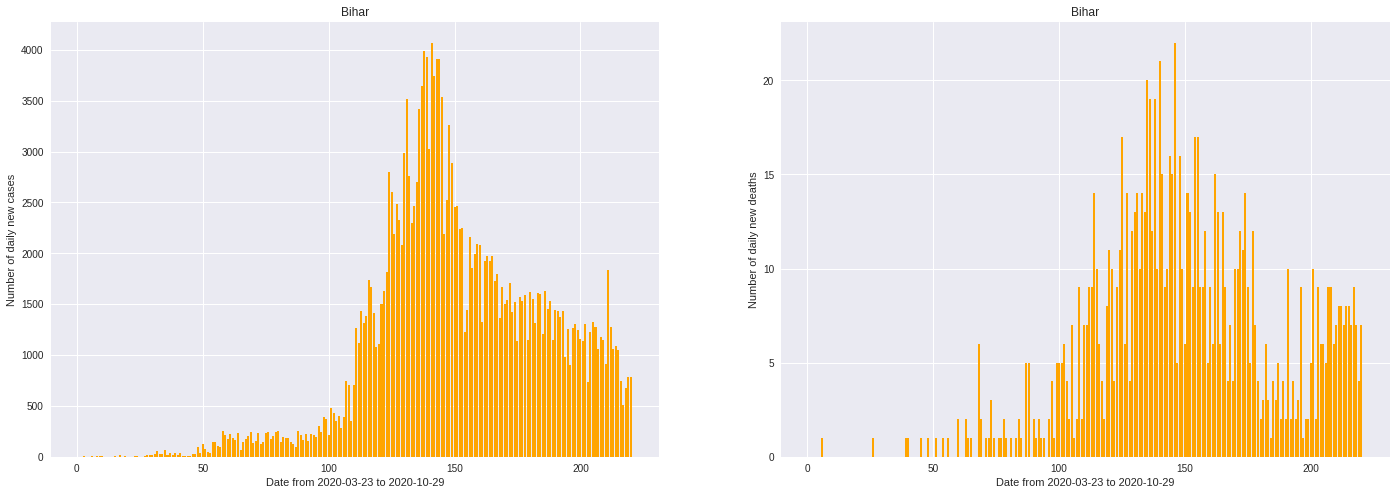

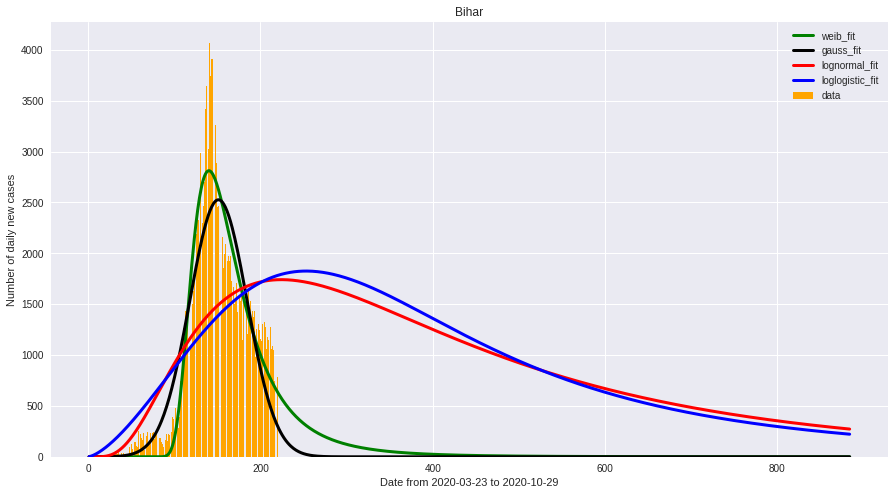

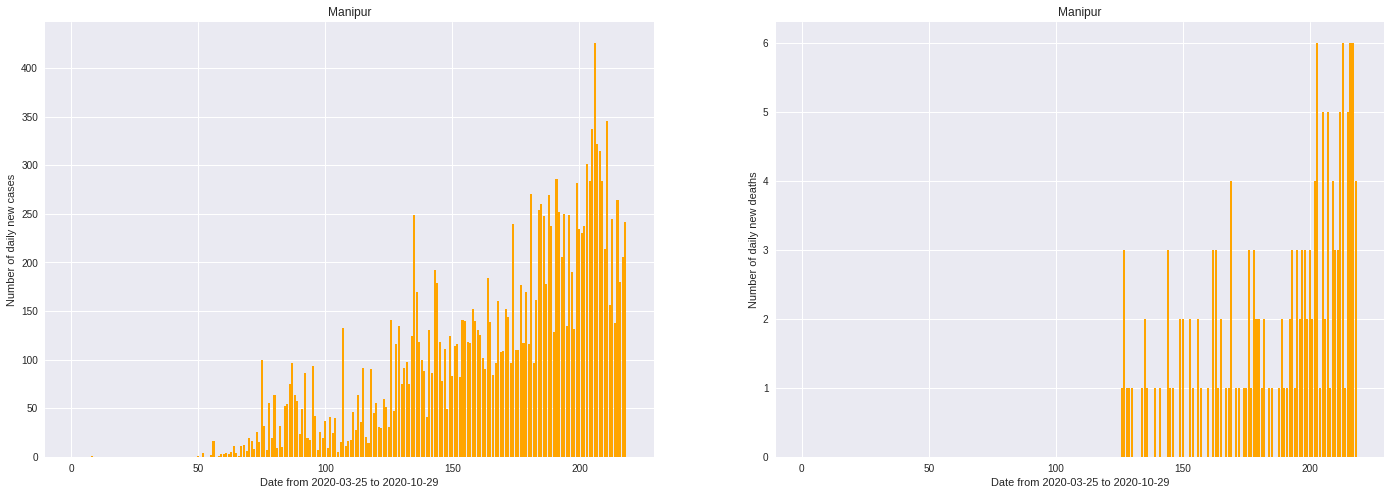

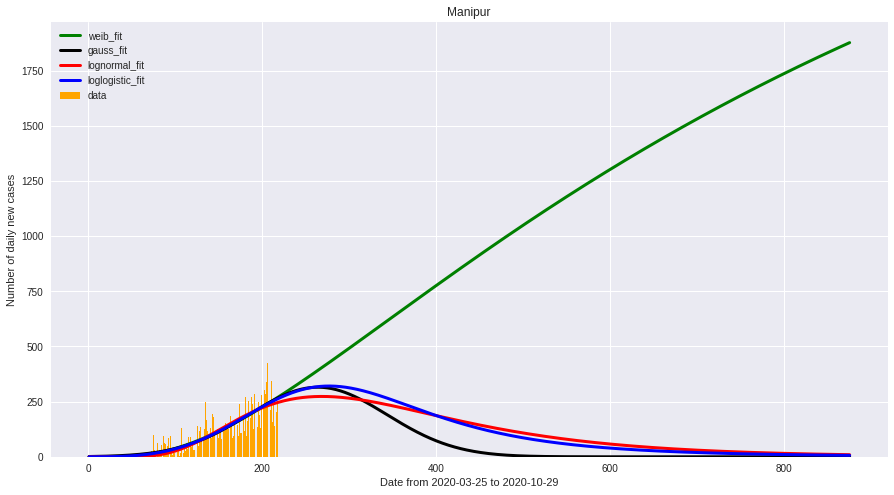

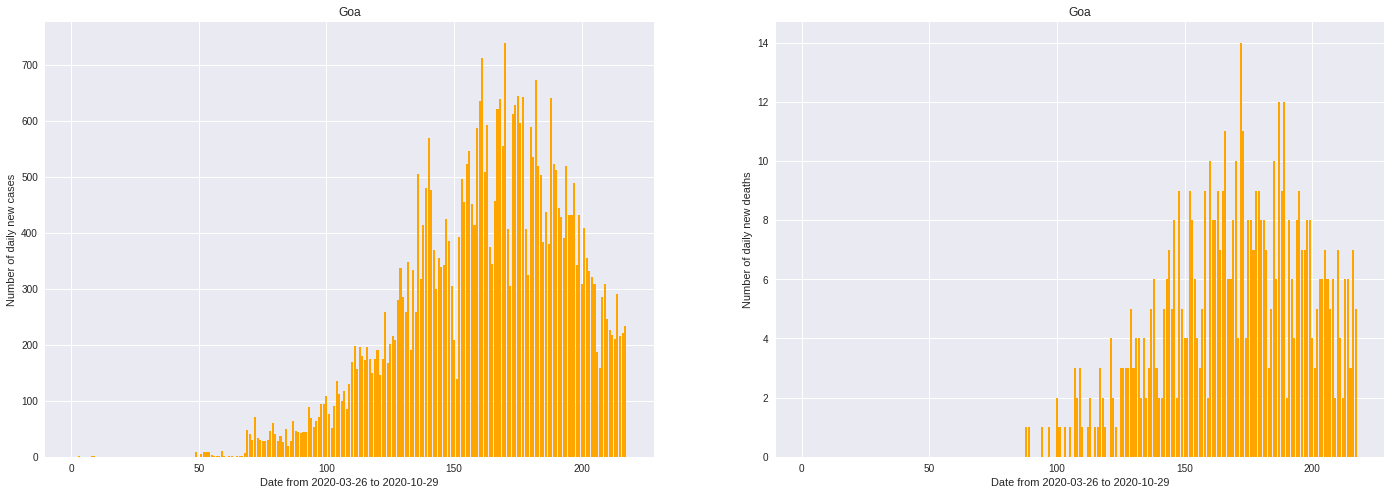

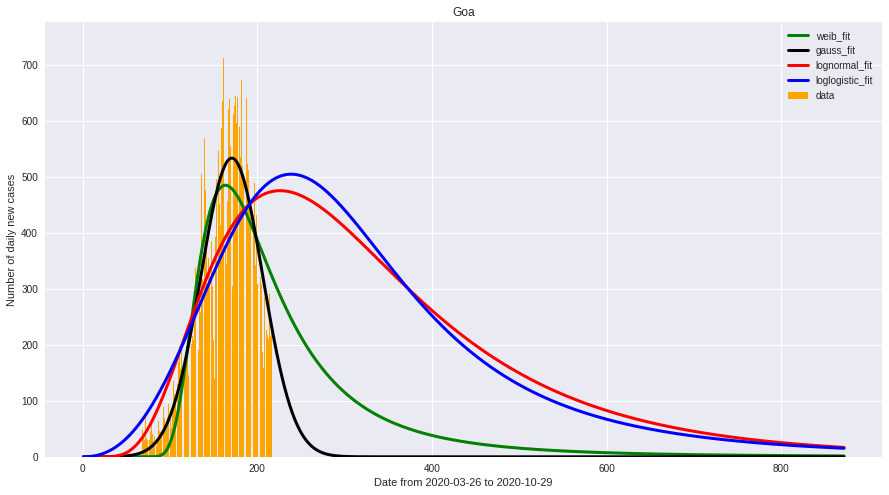

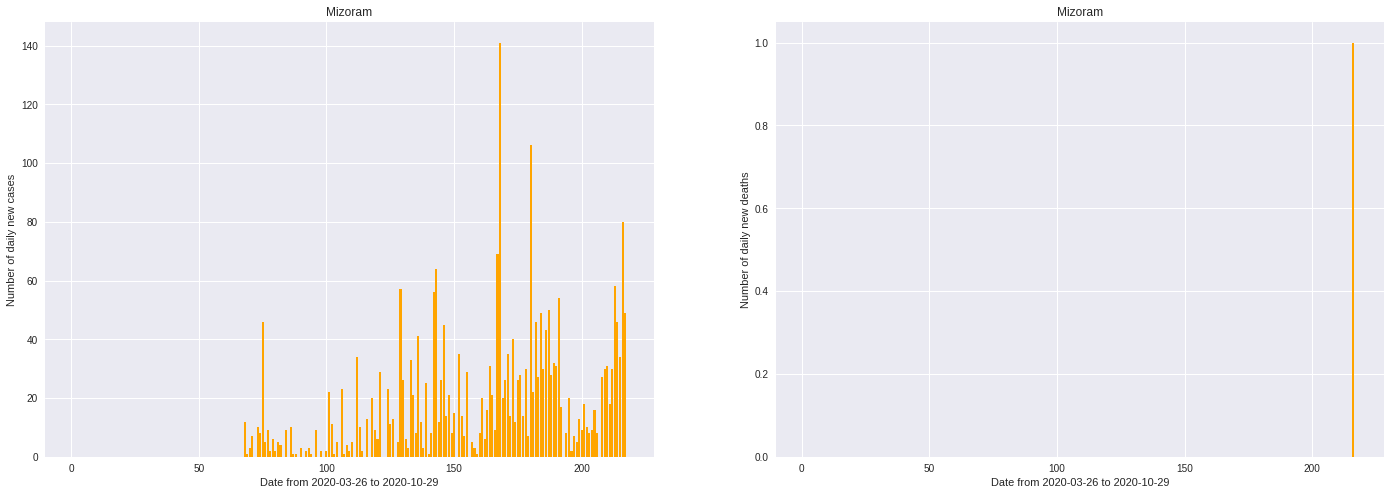

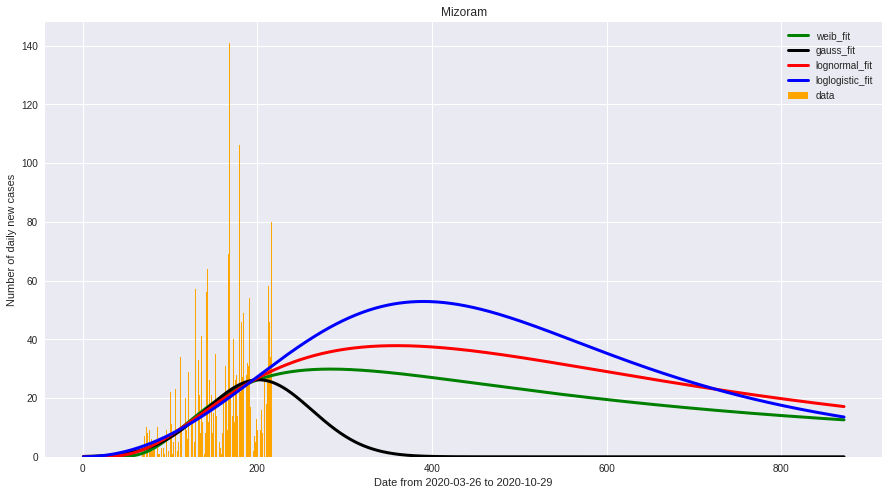

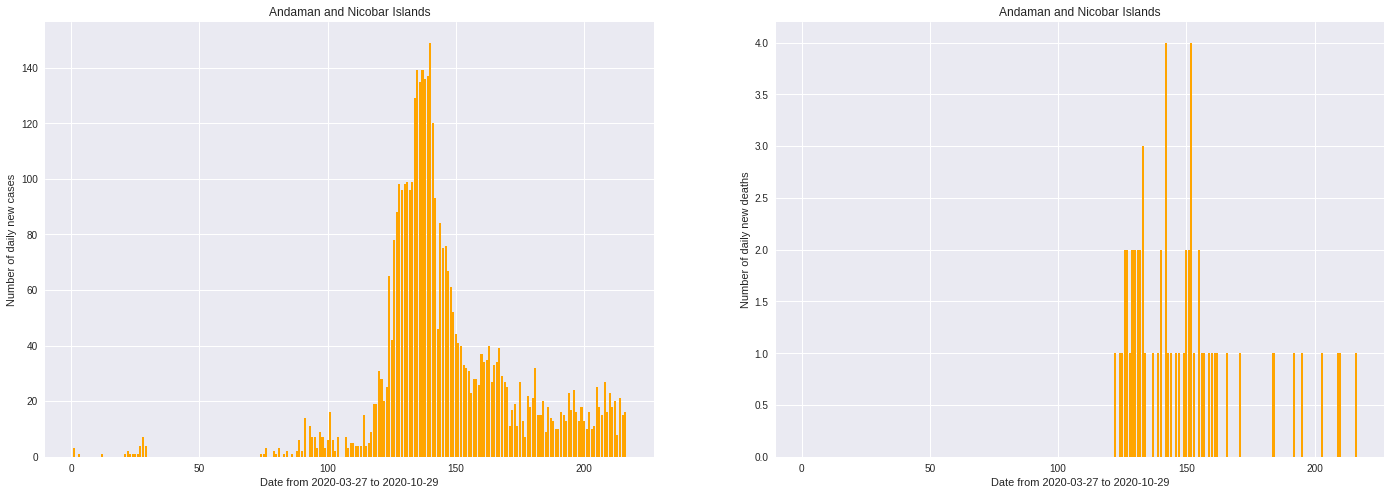

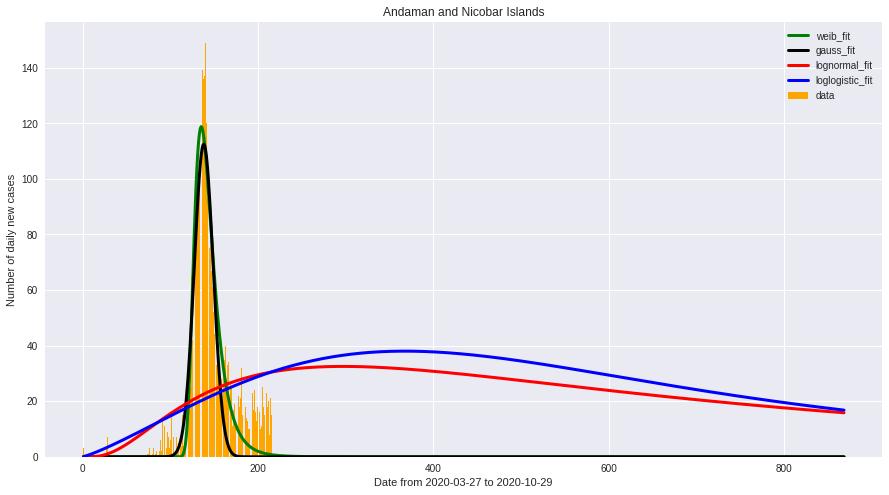

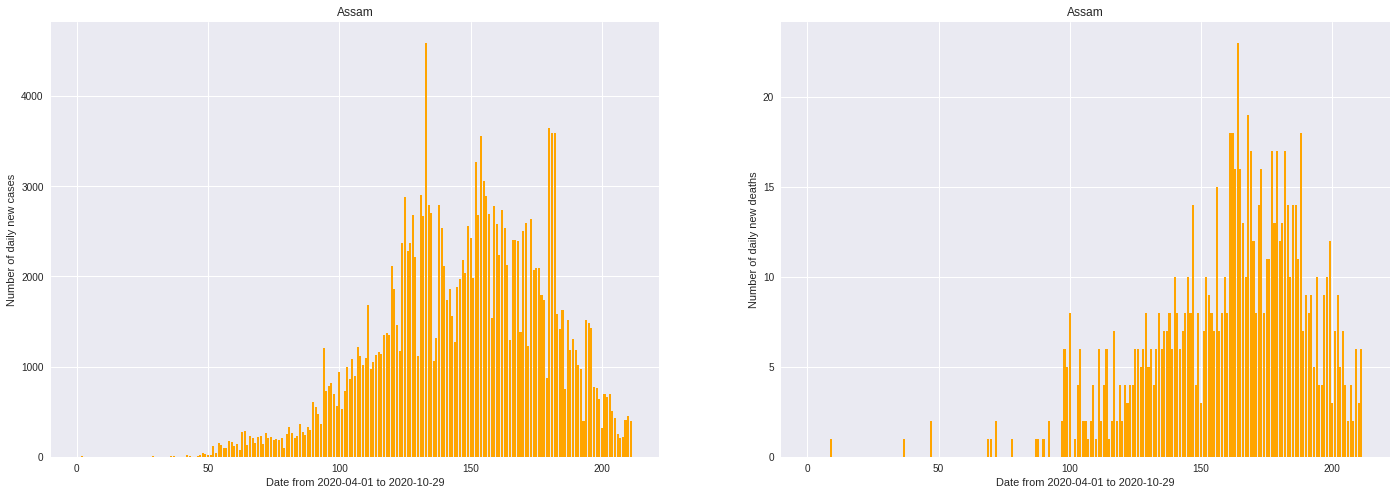

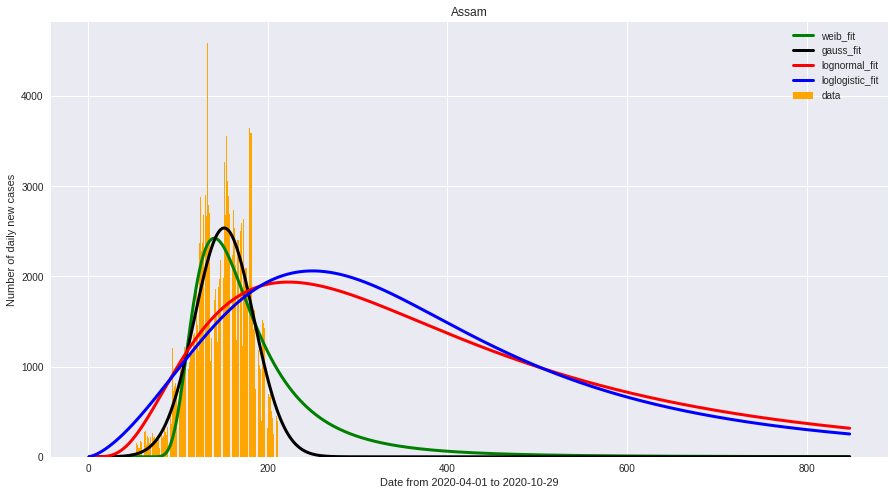

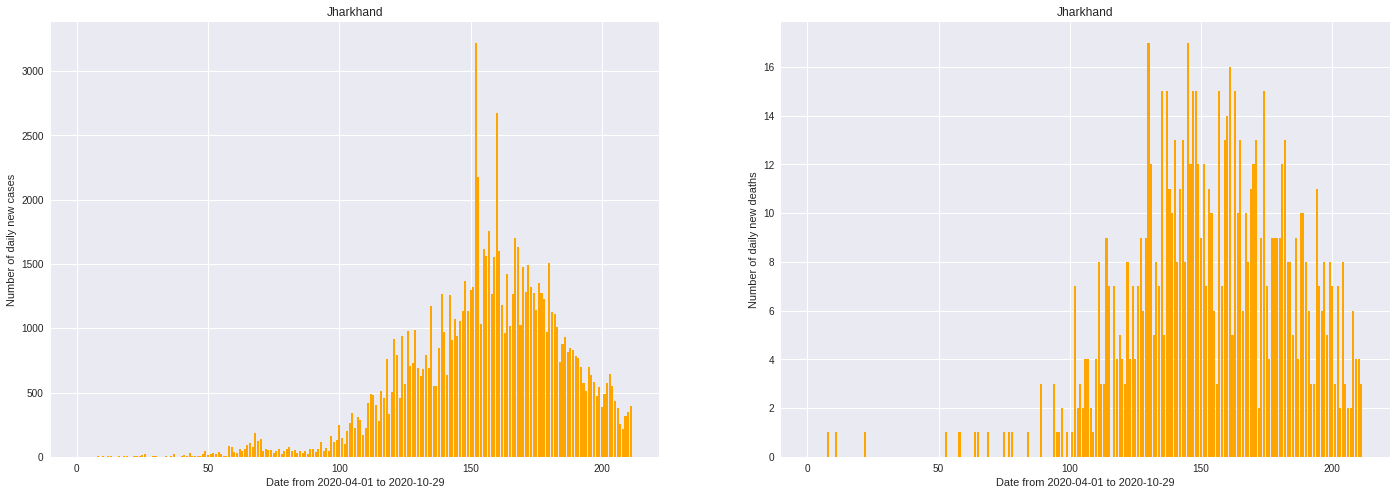

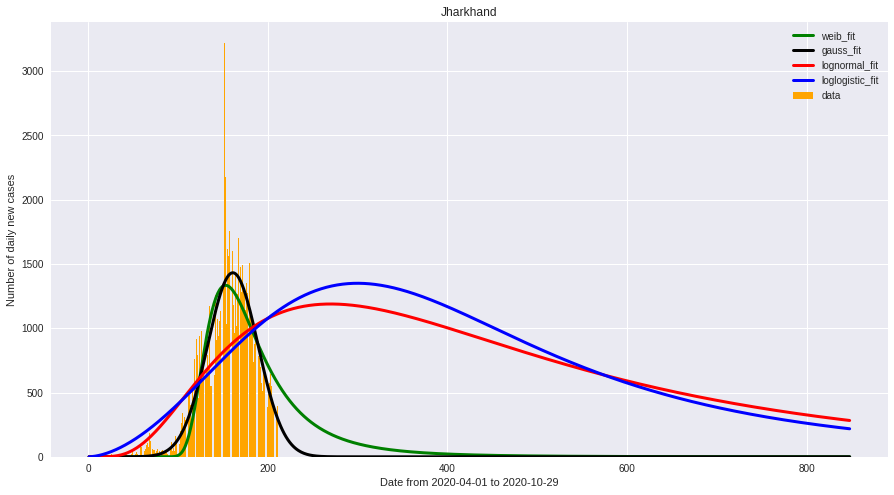

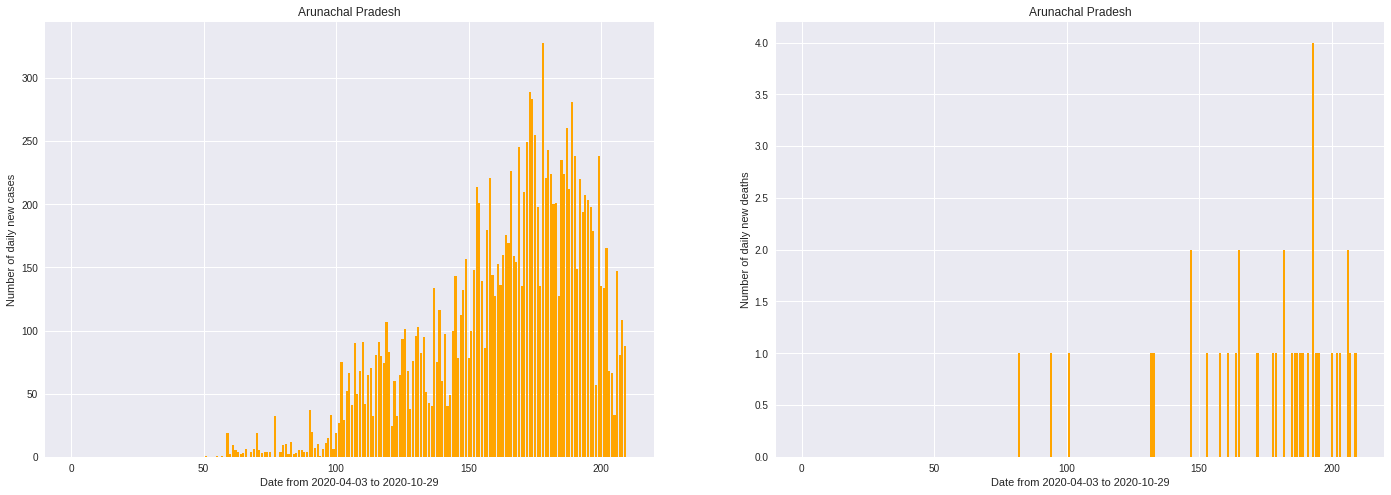

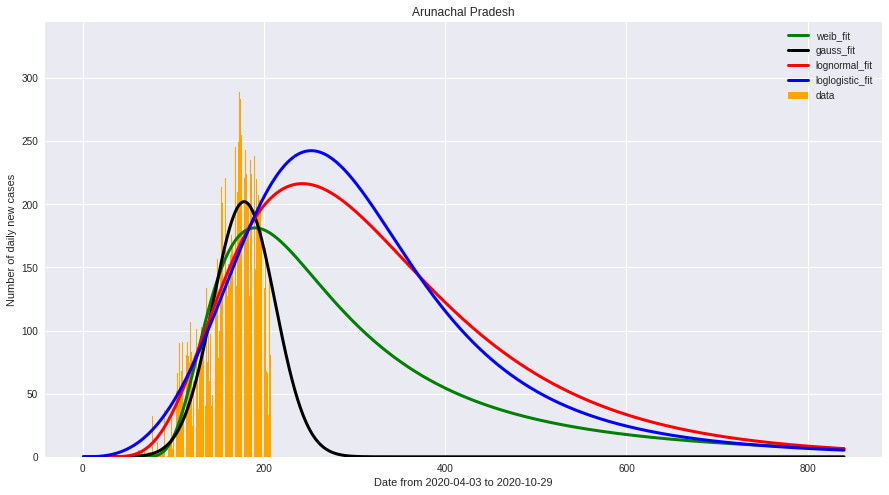

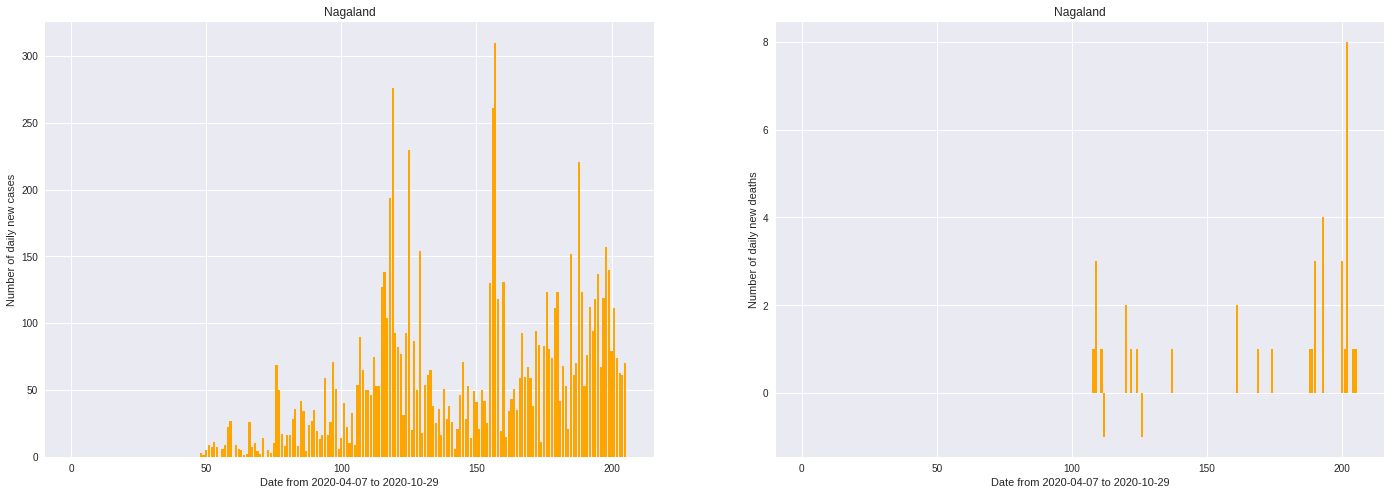

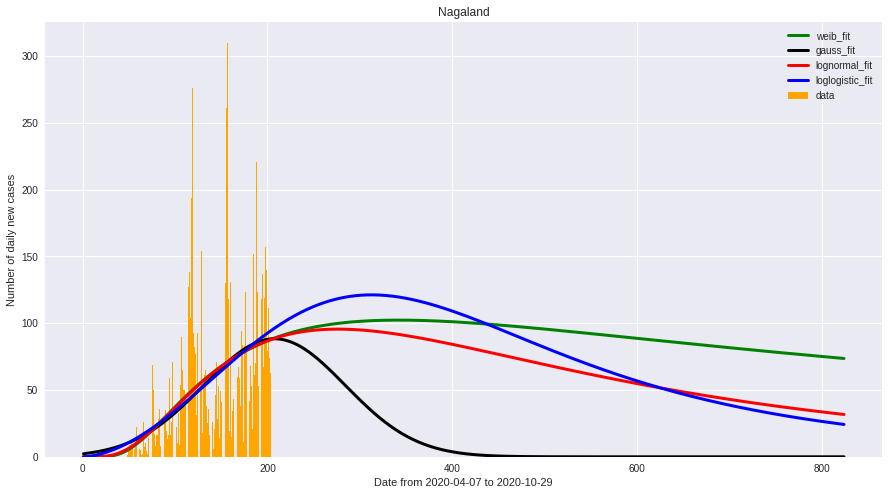

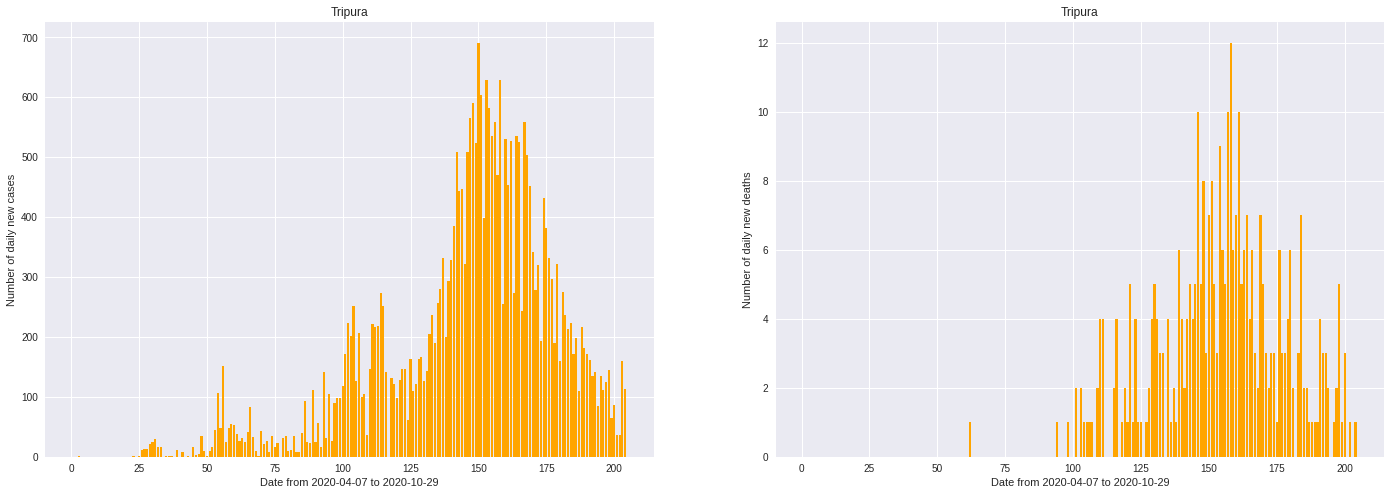

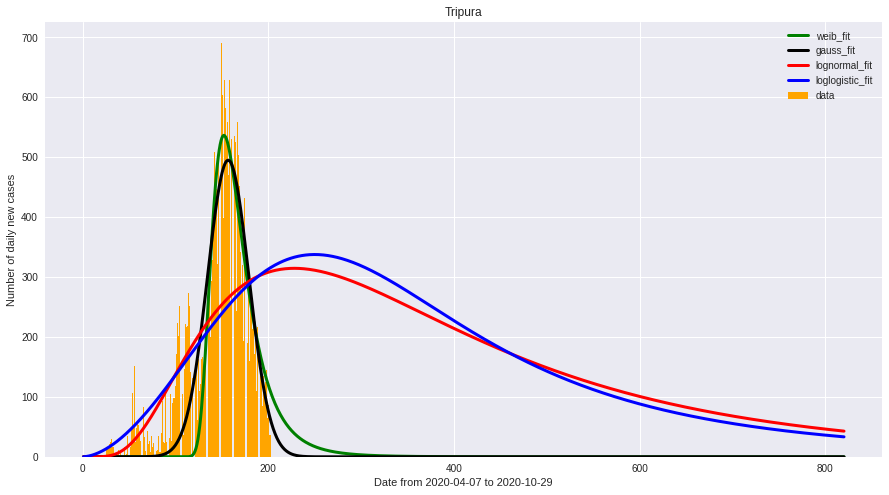

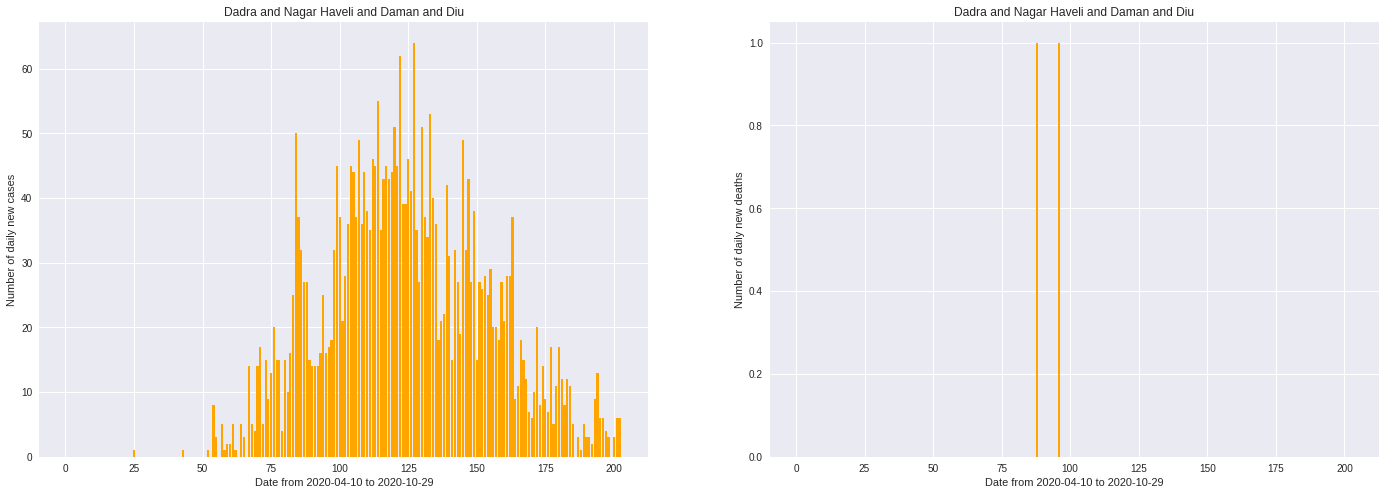

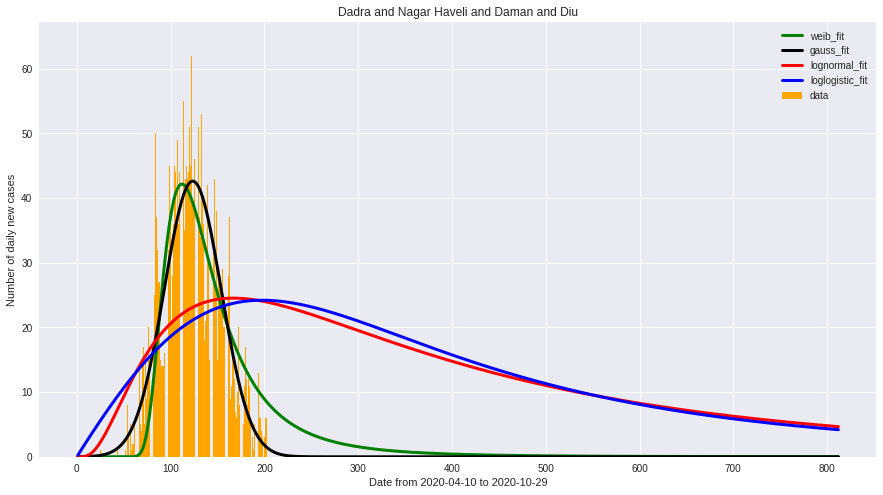

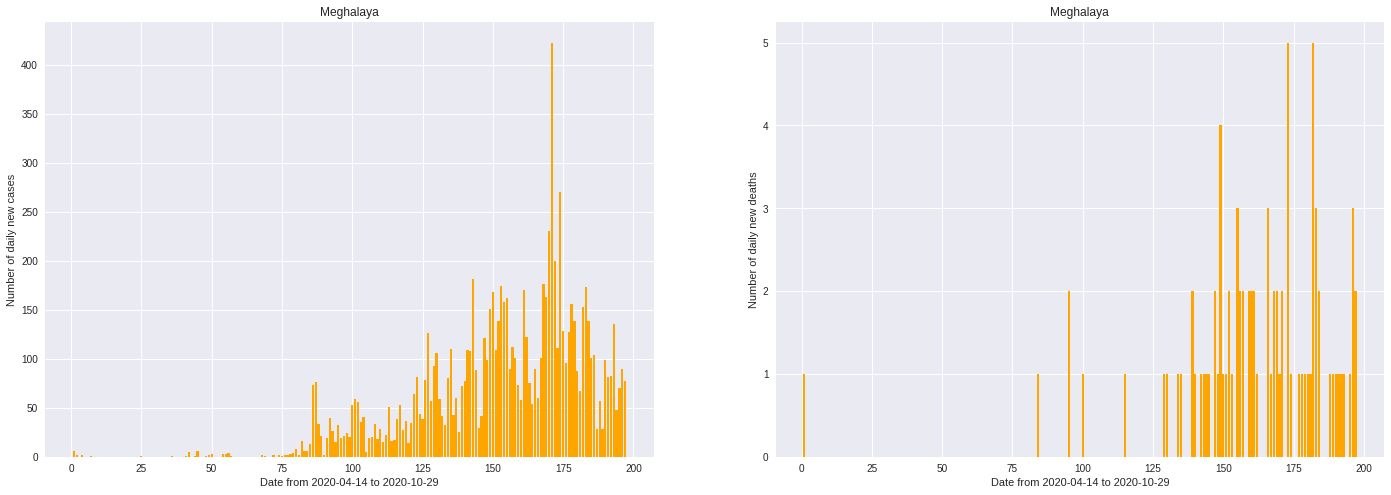

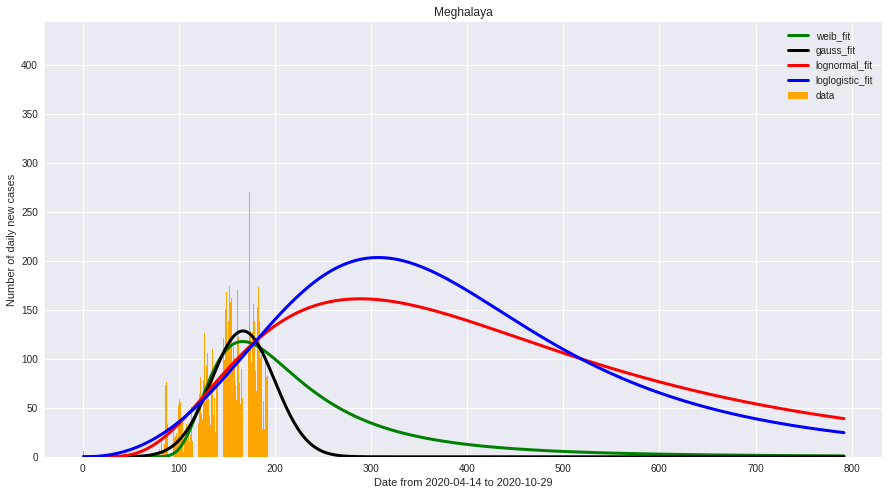

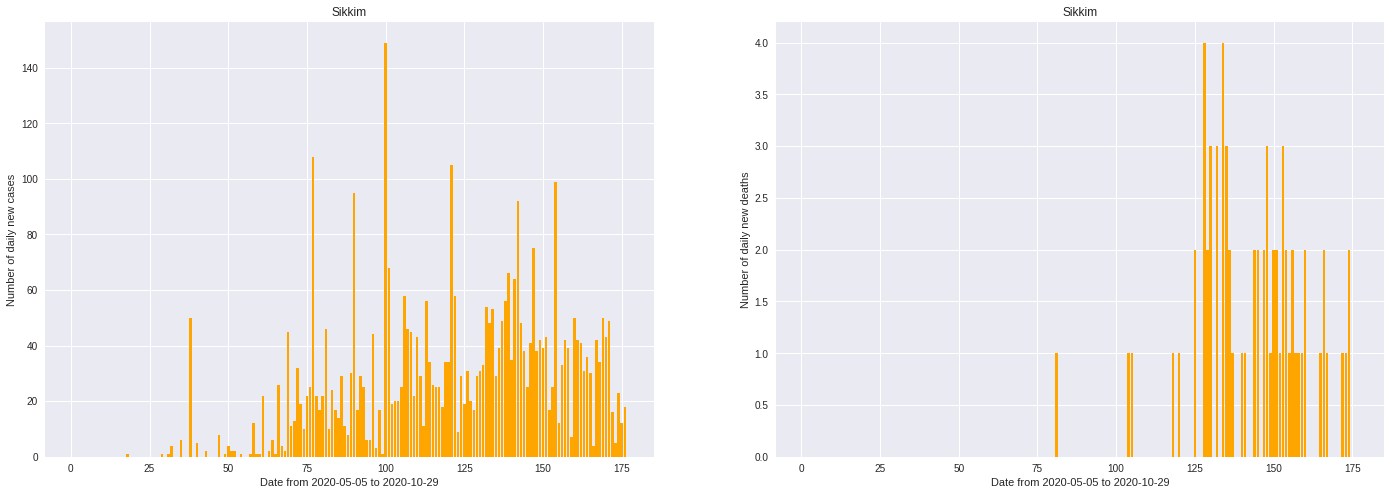

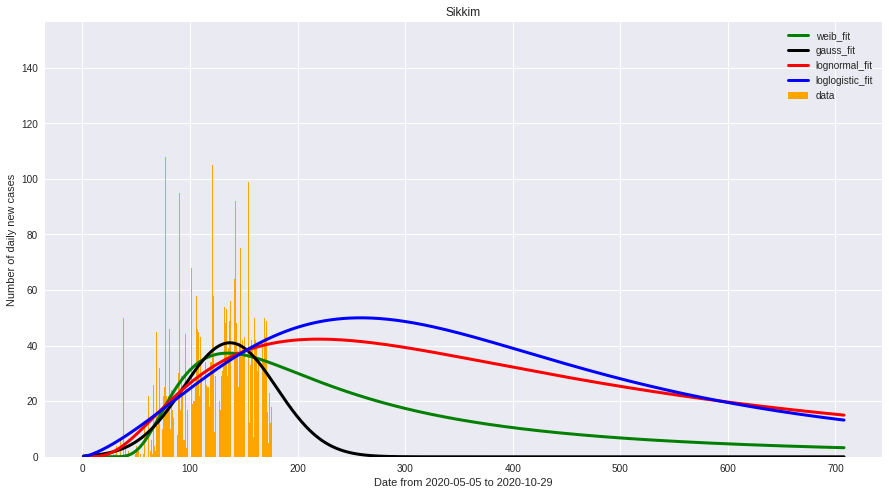

,State,Function,Mean Absolute Error,Mean Squared Error,R2-Score,Expected_Last_date,Expected_cases
0,Kerala,Weibull,0.027536,0.003332,0.920901,2022-10-07,706
1,Kerala,Gauss,0.026380,0.003212,0.917137,2021-03-26,0
2,Kerala,LogNormal,0.024177,0.003387,0.917215,2022-10-07,7
3,Kerala,LogLogistic,0.025337,0.003764,0.903354,2022-10-07,18
4,Delhi,Weibull,0.086297,0.013856,0.615816,2022-10-21,10805
...,...,...,...,...,...,...,...
135,Meghalaya,LogLogistic,0.059755,0.008795,0.001119,2022-06-13,24
136,Sikkim,Weibull,0.044576,0.004631,0.538068,2022-04-11,3
137,Sikkim,Gauss,0.046444,0.004279,0.513476,2021-01-15,0
138,Sikkim,LogNormal,0.051419,0.006256,0.295834,2022-04-11,14


In [12]:
data =  pd.read_csv('states.csv')
states = list(pd.unique(data['State']))
states.remove('State Unassigned')
states.remove('India')
states.remove('Lakshadweep')

Final_matrics = []
models = ['Weibull', 'Gauss', 'LogNormal', ' LogLogistic']
names = ['y', 'z', 't', 'l']

for state in states:
    df_1 = data[data['State'] == state]
    df_1['new_cases'] = df_1.loc[:, 'Confirmed'] - df_1.loc[:, 'Confirmed'].shift(1)
    df_1['new_deaths'] = df_1.loc[:, 'Deceased'] - df_1.loc[:, 'Deceased'].shift(1)
    df_1 = df_1[df_1.new_cases >= 0]
    df_1 = df_1.reset_index()
    df_1 = df_1.drop('index', axis = 1)
   
    
    index = max(df_1[df_1.Date <= '2020-10-30'].index)
    startdate = min(df_1.Date)
    enddate = max(df_1.Date[1:index])
    
    
    x_data, y_data_cases, y_data_deaths = (df_1.index.values[1:index], df_1.new_cases.values[1:index], df_1.new_deaths.values[1:index])
    x_data_max, y_data_cases_max, y_data_deaths_max = (max(x_data), max(y_data_cases), max(y_data_deaths))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(24,8))
    axes[0].bar(x_data, y_data_cases,color = 'orange')
    axes[0].set_title(state)
    axes[0].set_xlabel('Date from {} to {}'.format(startdate, enddate))
    axes[0].set_ylabel("Number of daily new cases")

    axes[1].bar(x_data, y_data_deaths,color = 'orange')
    axes[1].set_title(state)
    axes[1].set_xlabel('Date from {} to {}'.format(startdate, enddate))
    axes[1].set_ylabel("Number of daily new deaths");
    plt.savefig(state + '_data.png')
    
    xdata = x_data/x_data_max
    ydata_cases = y_data_cases/y_data_cases_max
    ydata_deaths = y_data_deaths/y_data_deaths_max
    
    popt_ind_weib, pcov_ind_weib = iterativeCurveFit(weib, xdata, ydata_cases)
    popt_ind_gauss, pcov_ind_gauss = iterativeCurveFit(gauss, xdata, ydata_cases)
    popt_ind_lognormal, pcov_ind_lognormal = iterativeCurveFit(lognormal, xdata, ydata_cases)
    popt_ind_loglogistic, pcov_ind_loglogistic = iterativeCurveFit(loglogistic, xdata, ydata_cases)
    
    # split data into train/test
    msk = np.random.rand(index-1) < 0.8
    train_x = xdata[msk]
    test_x = xdata[~msk]
    train_y = ydata_cases[msk]
    test_y = ydata_cases[~msk]

    y_hat = weib(test_x, *popt_ind_weib)
    z_hat = gauss(test_x, *popt_ind_gauss)
    t_hat = lognormal(test_x, *popt_ind_lognormal)
    l_hat = loglogistic(test_x, *popt_ind_loglogistic)

    hats = [y_hat, z_hat, t_hat, l_hat]

    xt = np.arange(1, 4*index)
    xt = 4*xt/max(xt)

    y = weib(xt, *popt_ind_weib)
    z = gauss(xt, *popt_ind_gauss)
    t = lognormal(xt, *popt_ind_lognormal)
    l = loglogistic(xt, *popt_ind_loglogistic)
    
    curves = [y, z, t, l]
    
    for i in range(4):
        Final_matrics.append({
            'State': state,
            'Function' : models[i],
            'Mean Absolute Error' : np.mean(np.absolute(hats[i] - test_y)),
            'Mean Squared Error' : np.mean((hats[i] - test_y) ** 2),
            'R2-Score' : r2_score(hats[i] , test_y),
            'Expected_Last_date': expectedEnd(names[i], curves[i], index, startdate)[0],
            'Expected_cases': expectedEnd(names[i], curves[i], index, startdate)[1]
        })
        

    plt.figure(figsize = (15,8))
    plt.bar(xdata*x_data_max, ydata_cases*y_data_cases_max, color = 'orange', label = 'data')
    plt.plot(xt*index, y*y_data_cases_max, 'green', linewidth = 3.0, label = 'weib_fit')
    plt.plot(xt*index, z*y_data_cases_max, 'black', linewidth = 3.0, label = 'gauss_fit')
    plt.plot(xt*index, t*y_data_cases_max, 'red', linewidth = 3.0, label = 'lognormal_fit')
    plt.plot(xt*index, l*y_data_cases_max, 'blue', linewidth = 3.0, label = 'loglogistic_fit')
    plt.title(state)
    plt.legend(loc = 'best')
    plt.ylabel("Number of daily new cases")
    plt.xlabel('Date from {} to {}'.format(startdate, enddate))
    plt.savefig(state + '.png')
    plt.show()

df = pd.DataFrame(Final_matrics, columns = ['State','Function', 'Mean Absolute Error', 'Mean Squared Error', 'R2-Score', 'Expected_Last_date','Expected_cases'])
df.to_csv('FinalMatrics_states.csv')

df

# General Data Analysis

In [14]:
df2 = pd.read_csv("states.csv")
df2["Date"] = pd.to_datetime(df2['Date'])
df_India = df2[(df2["State"] == "India")]
df_India = df_India[df_India["Date"] > "2021-01-15"].set_index("Date")
df_India.head(20)

,State,Confirmed,Recovered,Deceased,Other,Tested
Date,,,,,,
2021-01-16,India,10558715,10196223,152311,4370,186544868.0
2021-01-17,India,10572677,10210736,152456,4377,187093036.0
2021-01-18,India,10582664,10227863,152593,4387,187802827.0
2021-01-19,India,10596451,10245092,152755,4402,188566947.0
2021-01-20,India,10611730,10265163,152907,4413,189347782.0
2021-01-21,India,10626225,10282897,153068,4422,190148024.0
2021-01-22,India,10640548,10300063,153221,4435,190985119.0
2021-01-23,India,10655444,10316096,153377,4443,191766871.0
2021-01-24,India,10668676,10329244,153508,4449,192337117.0


# Vaccination Data Analysis

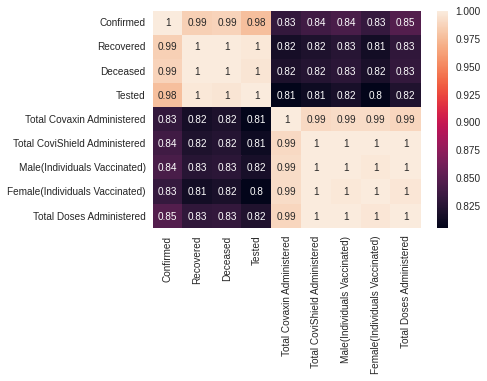

In [16]:
df4 = pd.read_csv("cowin_vaccine_data_statewise.csv")
df4["Updated On"] = pd.to_datetime(df4['Updated On'])
df_IND = df4[df4["State"]== "India"][df4["Updated On"] > "15/01/2021"].set_index("Updated On")
df_IND.head(10)

df_NEW = pd.concat([df_IND, df_India], axis = 1 )
df_NEW = df_NEW[df_NEW.index <"2021-03-30"]
df_NEW.head()

df_X = df_NEW[["Confirmed","Recovered","Deceased","Tested","Total Covaxin Administered","Total CoviShield Administered","Male(Individuals Vaccinated)","Female(Individuals Vaccinated)","Total Doses Administered"]]
corrMatrix = df_X.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# CoviShield Vaccine Data

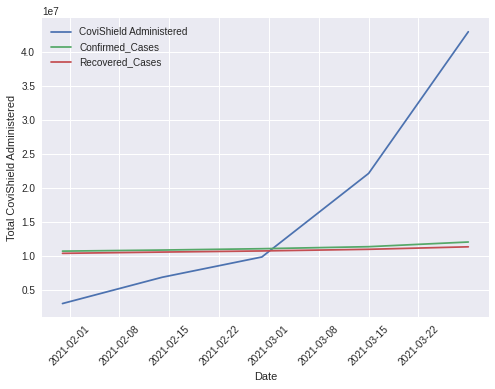

In [18]:
# df_X.loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]].index
# covishield

covid_date = df_X.loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]].index
covishield = df_X["Total CoviShield Administered"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]
confirmed_cases = df_X["Confirmed"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]
recovered_cases = df_X["Recovered"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]


plt.style.use("seaborn")
plt.plot(covid_date, covishield, linestyle = "solid")
plt.plot(covid_date, confirmed_cases, linestyle = "solid")
plt.plot(covid_date, recovered_cases, linestyle = "solid")
plt.xticks(rotation=45)
plt.legend(["CoviShield Administered","Confirmed_Cases","Recovered_Cases"],loc='upper left')
plt.xlabel("Date")
plt.ylabel("Total CoviShield Administered")

plt.show()

# CoVaxin Vaccine Data

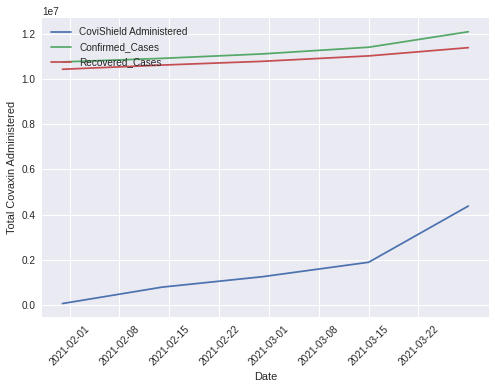

,Confirmed,Recovered,Deceased,Tested,Total Covaxin Administered,Total CoviShield Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Total Doses Administered
2021-01-16,10558715.0,10196223.0,152311.0,186544868.0,579.0,47697.0,23757.0,24517.0,48276.0
2021-01-17,10572677.0,10210736.0,152456.0,187093036.0,635.0,57969.0,27348.0,31252.0,58604.0
2021-01-18,10582664.0,10227863.0,152593.0,187802827.0,1299.0,98150.0,41361.0,58083.0,99449.0
2021-01-19,10596451.0,10245092.0,152755.0,188566947.0,3017.0,192508.0,81901.0,113613.0,195525.0
2021-01-20,10611730.0,10265163.0,152907.0,189347782.0,3946.0,247334.0,98111.0,153145.0,251280.0
...,...,...,...,...,...,...,...,...,...
2021-03-08,11244625.0,10897486.0,157966.0,222716796.0,NaN,NaN,NaN,NaN,NaN
2021-03-09,11262498.0,10918129.0,158099.0,223479877.0,NaN,NaN,NaN,NaN,NaN
2021-03-10,11285349.0,10936283.0,158224.0,224258293.0,NaN,NaN,NaN,NaN,NaN
2021-03-11,11308647.0,10951375.0,158343.0,224998638.0,NaN,NaN,NaN,NaN,NaN


In [19]:
covid_date = df_X.loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]].index
covaxin = df_X["Total Covaxin Administered"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]
confirmed_cases = df_X["Confirmed"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]
recovered_cases = df_X["Recovered"].loc[["2021-01-31","2021-02-14","2021-02-28","2021-03-15","2021-03-29"]]


plt.style.use("seaborn")
plt.plot(covid_date, covaxin, linestyle = "solid")
plt.plot(covid_date, confirmed_cases, linestyle = "solid")
plt.plot(covid_date, recovered_cases, linestyle = "solid")
plt.xticks(rotation=45)
plt.legend(["CoviShield Administered","Confirmed_Cases","Recovered_Cases"],loc='upper left')
plt.xlabel("Date")
plt.ylabel("Total Covaxin Administered")

plt.show()

df_X.head(10)

df_X.sort_values("Total Doses Administered")

# Bottom 5 States

Text(0, 0.5, 'Total Doses Administered(in log scale)')

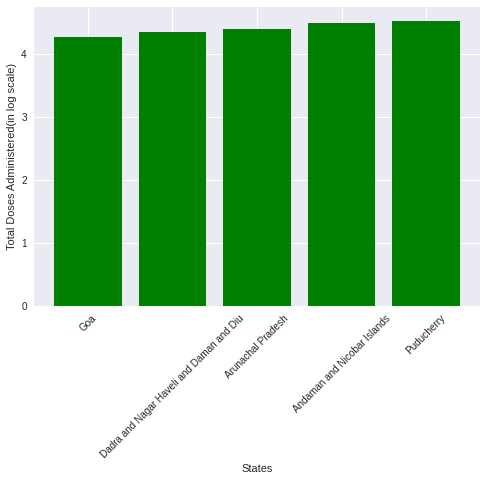

In [20]:
df6 = pd.read_csv("cowin_vaccine_data_statewise.csv")
df6 = df6.sort_values("Total Doses Administered")
X = df6["State"][33:38]
Y = df6["Total Doses Administered"][33:38]
plt.bar(X,np.log(Y), color = "green")
plt.xticks(rotation = 45)
plt.xlabel("States")
plt.ylabel("Total Doses Administered(in log scale)")

# Top 5 States

Text(0, 0.5, 'Total Doses Administered(in log scale)')

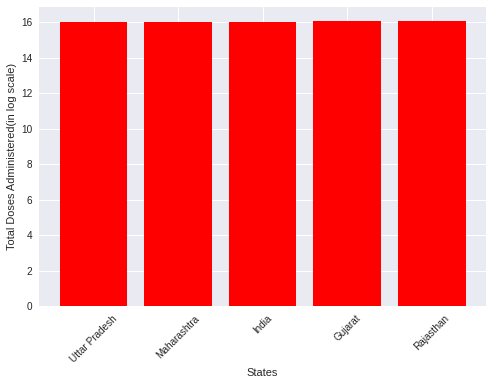

In [21]:
X1 = df6["State"][3150:3156]
Y1 = df6["Total Doses Administered"][3150:3156]
plt.bar(X1,np.log(Y1), color = "red")
plt.xticks(rotation = 45)
plt.xlabel("States")
plt.ylabel("Total Doses Administered(in log scale)")